In [1]:
import torch
import numpy as np
import os
import glob
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('/Users/sarahurbut/aladynoulli2/pyScripts/')
from cluster_g_logit_init_acceptpsi_flatlam_healthtoo import *

In [2]:



# Base directory containing all output folders
base_dir = '/Users/sarahurbut/Dropbox (Personal)/from_AWS/resultstraj/'

# List all output directories
output_dirs = sorted(glob.glob(os.path.join(base_dir, 'output_*')))

first_model = torch.load(os.path.join(base_dir, 'output_0_10000/model.pt'))

/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_2103/721760235.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  first_model = torch.load(os.path.join(base_dir,

In [3]:
disease_names = first_model['disease_names']
disease_names = disease_names[0].tolist()

In [4]:
# Load first model to get phi_kd
first_model = torch.load('/Users/sarahurbut/Dropbox (Personal)/from_AWS/resultstraj/output_0_10000/model.pt')
phi_kd = first_model['model_state_dict']['phi']  # Shape should be (K, D)
all_lambdas = np.load('/Users/sarahurbut/aladynoulli2/pyScripts/oldstuff/all_lambdas_combined.npy')
# Calculate pi for all people
# all_lambdas shape is (N, K, T)
# phi_kd shape is (K, D)
# Need to calculate for each timepoint
T = all_lambdas.shape[2]
D = phi_kd.shape[1]


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_2103/2998891733.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  first_model = torch.load('/Users/sarahurbut/Dr

In [5]:


# Convert to thetas first
all_thetas = torch.softmax(torch.tensor(all_lambdas), dim=1).numpy()

epsilon = 1e-8
# Convert lambdas to thetas


# Get phi probabilities
phi_prob = torch.sigmoid(torch.tensor(phi_kd)).numpy()



/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_2103/1405816475.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  phi_prob = torch.sigmoid(torch.tensor(phi_kd)).numpy()


In [6]:
import time

# Test with first 10K people
test_size = 10000
test_thetas = all_thetas[:test_size]

# Time the operation
start_time = time.time()
test_pi = np.einsum('nkt,kdt->ndt', test_thetas, phi_prob)
end_time = time.time()

# Calculate timing
elapsed_time = end_time - start_time
estimated_full_time = elapsed_time * (len(all_thetas) / test_size)

print(f"Time for {test_size} people: {elapsed_time:.2f} seconds")
print(f"Estimated time for all {len(all_thetas)} people: {estimated_full_time:.2f} seconds ({estimated_full_time/60:.2f} minutes)")

# Verify shapes and values
print("\nVerification:")
print(f"Test pi shape: {test_pi.shape}")
print(f"Range of values: [{test_pi.min():.6f}, {test_pi.max():.6f}]")
print(f"Mean value: {test_pi.mean():.6f}")

Time for 10000 people: 6.15 seconds
Estimated time for all 400000 people: 245.92 seconds (4.10 minutes)

Verification:
Test pi shape: (10000, 348, 52)
Range of values: [0.000000, 0.018879]
Mean value: 0.000143


In [7]:
# 1. Full calculation
print("Starting full calculation...")
start_time = time.time()
pi_pred = np.einsum('nkt,kdt->ndt', all_thetas, phi_prob)
print(f"Full calculation took: {(time.time() - start_time)/60:.2f} minutes")

# 2. Additional verification
print("\nVerification:")
print(f"Full pi shape: {pi_pred.shape}")
print(f"Range of values: [{pi_pred.min():.6f}, {pi_pred.max():.6f}]")
print(f"Mean value: {pi_pred.mean():.6f}")

Starting full calculation...
Full calculation took: 4.10 minutes

Verification:
Full pi shape: (400000, 348, 52)
Range of values: [0.000000, 0.020623]
Mean value: 0.000143


In [10]:
type(pi_pred)

numpy.ndarray

In [8]:

refs = torch.load('/Users/sarahurbut/aladynoulli2/pyScripts/reference_trajectories.pt')
signature_refs = refs['signature_refs']
# 3. Compare with original model
print("\nComparing with original model predictions...")
# Load and initialize model properly
model_path = '/Users/sarahurbut/Dropbox (Personal)/from_AWS/resultstraj/output_0_10000/model.pt'
checkpoint = torch.load(model_path)

model = AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest(
    N=checkpoint['hyperparameters']['N'],
    D=checkpoint['hyperparameters']['D'],
    T=checkpoint['hyperparameters']['T'],
    K=20,
    P=checkpoint['hyperparameters']['P'],
    init_var_scaler=1e-1,
    G=checkpoint['G'],
    Y=checkpoint['Y'],
    genetic_scale=3,
    prevalence_t=checkpoint['prevalence_t'],
    signature_references=signature_refs,
    healthy_reference=True,
    disease_names=checkpoint['disease_names']
)

model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

with torch.no_grad():
    original_pi, _, _ = model.forward()
    original_pi = original_pi.cpu().numpy()


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_2103/1980400321.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  refs = torch.load('/Users/sarahurbut/aladynoul


Comparing with original model predictions...
Lambda kernel condition number: 56314924.00
Phi kernel condition number: 59684776.00

Cluster Sizes:
Cluster 0: 14 diseases
Cluster 1: 7 diseases
Cluster 2: 21 diseases
Cluster 3: 15 diseases
Cluster 4: 17 diseases
Cluster 5: 16 diseases
Cluster 6: 57 diseases
Cluster 7: 18 diseases
Cluster 8: 13 diseases
Cluster 9: 11 diseases
Cluster 10: 18 diseases
Cluster 11: 12 diseases
Cluster 12: 26 diseases
Cluster 13: 7 diseases
Cluster 14: 9 diseases
Cluster 15: 8 diseases
Cluster 16: 7 diseases
Cluster 17: 11 diseases
Cluster 18: 6 diseases
Cluster 19: 55 diseases

Calculating gamma for k=0:
Number of diseases in cluster: 14
Base value (first 5): tensor([-18.4207, -18.4207, -17.3858, -16.3508, -16.3508])
Base value centered (first 5): tensor([-0.5458, -0.5458,  0.4891,  1.5240,  1.5240])
Base value centered mean: 3.23352810482902e-06
Gamma init for k=0 (first 5): tensor([ 0.0013,  0.0101,  0.0173,  0.0224, -0.0156])

Calculating gamma for k=1:
Nu

In [9]:

# Compare first few predictions
print("\nFirst few predictions comparison:")
person_idx = 3000
disease_idx = 0
print(f"Person {person_idx}, Disease {disease_idx}:")
print(f"Our calculation: {pi_pred[person_idx, disease_idx, 0]:.6f}")
print(f"Original model: {original_pi[person_idx, disease_idx, 0]:.6f}")


First few predictions comparison:
Person 3000, Disease 0:
Our calculation: 0.000015
Original model: 0.000015


In [10]:
predicted_risk_2d = np.mean(pi_pred, axis=0)  # Shape will be (348, 52)

print("Predicted risk shape:", predicted_risk_2d.shape)  # Should be (348, 52)
print("Range of values:", predicted_risk_2d.min(), predicted_risk_2d.max())
print("Mean value:", predicted_risk_2d.mean())

Predicted risk shape: (348, 52)
Range of values: 3.0598596846706046e-09 0.008507027960416498
Mean value: 0.00014321941496718245


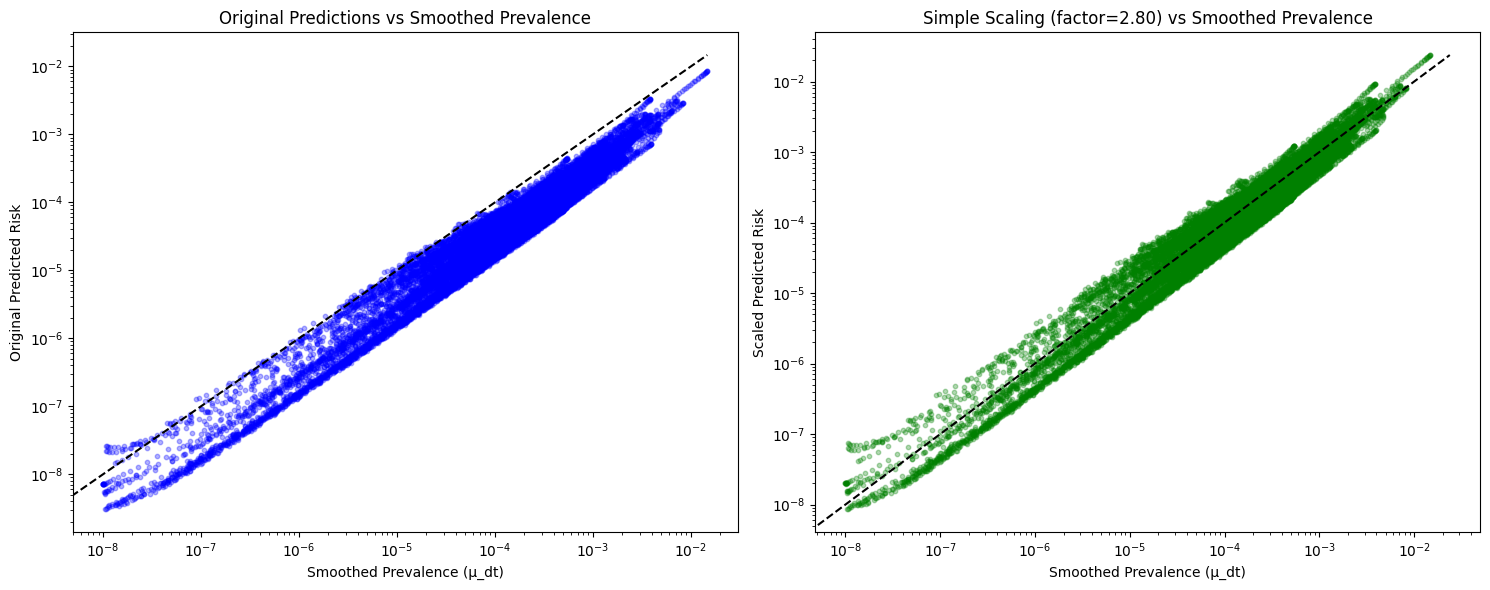

In [15]:
# Get μ_dt from checkpoint and predictions
mu_dt = first_model['prevalence_t']  # Shape: (348, 52)
scale_factor = np.mean(mu_dt) / np.mean(predicted_risk_2d)
scaled_risk_2d = predicted_risk_2d * scale_factor

# Create two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Original predictions vs μ_dt
ax1.scatter(mu_dt.flatten(), predicted_risk_2d.flatten(), 
           alpha=0.3, color='blue', s=10)
ax1.plot([0, max(mu_dt.max(), predicted_risk_2d.max())], 
         [0, max(mu_dt.max(), predicted_risk_2d.max())], 
         'k--', label='x=y')
ax1.set_xlabel('Smoothed Prevalence (μ_dt)')
ax1.set_ylabel('Original Predicted Risk')
ax1.set_title('Original Predictions vs Smoothed Prevalence')
ax1.set_xscale('log')
ax1.set_yscale('log')

# Scaled predictions vs μ_dt
ax2.scatter(mu_dt.flatten(), scaled_risk_2d.flatten(), 
           alpha=0.3, color='green', s=10)
ax2.plot([0, max(mu_dt.max(), scaled_risk_2d.max())], 
         [0, max(mu_dt.max(), scaled_risk_2d.max())], 
         'k--', label='x=y')
ax2.set_xlabel('Smoothed Prevalence (μ_dt)')
ax2.set_ylabel('Scaled Predicted Risk')
ax2.set_title(f'Simple Scaling (factor={scale_factor:.2f}) vs Smoothed Prevalence')
ax2.set_xscale('log')
ax2.set_yscale('log')

plt.tight_layout()
plt.show()

In [16]:
def load_model_essentials(base_path='/Users/sarahurbut/Dropbox (Personal)/data_for_running/'):
    """
    Load all essential components
    """
    print("Loading components...")
    
    # Load large matrices
    Y = torch.load(base_path + 'Y_tensor.pt')
    E = torch.load(base_path + 'E_matrix.pt')
    G = torch.load(base_path + 'G_matrix.pt')
    
    # Load other components
    essentials = torch.load(base_path + 'model_essentials.pt')
    
    print("Loaded all components successfully!")
    
    return Y, E, G, essentials

# Load and initialize model:
Y, E, G, essentials = load_model_essentials()

# Function to find interesting cases
def find_theta_changes_at_diagnosis(Y, thetas, n_examples=5):
    interesting_cases = []
    
    # For each person
    for i in range(len(Y)):
        # Find where diagnoses happen
        diagnoses = np.where(Y[i] == 1)
        
        if len(diagnoses[0]) > 0:  # If they have any diagnoses
            for d, t in zip(*diagnoses):
                if t > 0 and t < 51:  # Skip diagnoses at t=0 and ensure we can look before/after
                    # Look at theta change around diagnosis
                    theta_before = thetas[i, :, t-1]
                    theta_after = thetas[i, :, t]
                    
                    # Calculate change in thetas
                    theta_change = np.abs(theta_after - theta_before)
                    
                    if np.max(theta_change) > 0.1:  # Arbitrary threshold
                        interesting_cases.append({
                            'person': i,
                            'disease': d,
                            'time': t,
                            'max_change': np.max(theta_change)
                        })
    
    # Sort by magnitude of change
    interesting_cases.sort(key=lambda x: x['max_change'], reverse=True)
    return interesting_cases[:n_examples]

Loading components...


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_6210/3386527837.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Y = torch.load(base_path + 'Y_tensor.pt')
/var

Loaded all components successfully!


In [17]:
def find_theta_changes_at_diagnosis(Y, thetas, n_examples=5):
    interesting_cases = []
    
    # For each person (use length of thetas, not Y)
    for i in range(len(thetas)):
        # Find where diagnoses happen
        diagnoses = np.where(Y[i] == 1)
        
        if len(diagnoses[0]) > 0:  # If they have any diagnoses
            for d, t in zip(*diagnoses):
                if t > 0 and t < 51:  # Skip diagnoses at t=0 and ensure we can look before/after
                    # Look at theta change around diagnosis
                    theta_before = thetas[i, :, t-1]
                    theta_after = thetas[i, :, t]
                    
                    # Calculate change in thetas
                    theta_change = np.abs(theta_after - theta_before)
                    
                    if np.max(theta_change) > 0.01:  # Arbitrary threshold
                        interesting_cases.append({
                            'person': i,
                            'disease': d,
                            'time': t,
                            'max_change': np.max(theta_change)
                        })
    
    # Sort by magnitude of change
    interesting_cases.sort(key=lambda x: x['max_change'], reverse=True)
    return interesting_cases[:n_examples]

# Find examples
examples = find_theta_changes_at_diagnosis(Y, all_thetas)

# Print first few examples to verify
print("Found examples:")
for case in examples[:5]:
    print(f"Person {case['person']}: Disease {case['disease']} at time {case['time']}, max change: {case['max_change']:.3f}")

Found examples:
Person 5543: Disease 343 at time 7, max change: 0.045
Person 380356: Disease 52 at time 9, max change: 0.043
Person 380356: Disease 54 at time 9, max change: 0.043
Person 380356: Disease 109 at time 9, max change: 0.043
Person 380356: Disease 194 at time 9, max change: 0.043


In [18]:
# Load cluster assignments
cluster_ids = torch.load('/Users/sarahurbut/Dropbox (Personal)/data_for_running/initial_clusters_400k.pt')
cluster_i=first_model['clusters']

/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_6210/3741113616.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cluster_ids = torch.load('/Users/sarahurbut/Dr

In [19]:
cluster_i

array([ 3,  3, 16, 16, 16, 16, 16, 19,  3, 16, 17, 17, 17,  6, 19, 19, 19,
       19,  8,  8,  8, 13,  3, 13,  6,  6,  6,  6,  6,  6,  6,  3,  3, 17,
        3,  2,  3,  3,  3, 19,  8,  8,  3, 19, 19,  7, 15, 15, 15, 15, 15,
        7,  5,  3, 16, 16, 16, 16, 16, 16,  7,  2, 16, 16, 16,  3,  7,  7,
        3,  3, 14,  3,  7,  3,  9,  3,  7, 11,  3,  1,  3,  3, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10,  3,  3,  3, 19, 19,  3, 19, 19,  3, 10,
        3,  3,  3,  0,  0,  0,  0,  7, 19,  5,  5,  5,  5,  5,  5,  0,  3,
        0,  0,  0,  3,  3,  0,  0,  0,  0,  3,  3,  0,  0, 11, 11, 11, 11,
       11, 11, 11,  3,  3,  3,  3,  3,  3, 17, 16, 16,  3,  3,  4,  4,  4,
        3,  3,  4,  3,  4, 14, 16, 14,  7, 14, 14, 14, 14, 14, 14,  0, 16,
       14, 16,  3,  3,  3,  3,  3,  3,  3,  2,  7,  2,  2,  2,  2,  2,  2,
        2,  2,  3,  2,  2,  2,  3,  3,  2,  3, 17, 17, 17,  3, 17, 17, 17,
       16,  3,  7, 17, 17, 16, 18, 17, 17,  7,  3, 18, 18, 18, 18, 18, 18,
       18, 18,  3,  3, 17

In [20]:
# Load cluster assignments
cluster_ids = torch.load('/Users/sarahurbut/Dropbox (Personal)/data_for_running/initial_clusters_400k.pt')
cluster_ids=first_model['clusters']
def find_interesting_cases(Y, all_thetas, cluster_ids, n_examples=5, window=5):
    interesting_cases = {}  # Use dict with person as key to avoid duplicates
    
      # Use length of all_thetas for number of people
    n_people = len(all_thetas)
    print(f"Looking at {n_people} people")
    
    # Look at all people
    for i in range(n_people):
    # Look at all people
    
        # Find their diagnoses
        diseases = np.where(Y[i].sum(axis=1) > 0)[0]
        
        if len(diseases) > 0:
            max_change = 0
            best_case = None
            
            for d in diseases:
                # Get diagnosis time
                t = np.where(Y[i, d] == 1)[0][0]
                
                if t > window and t < (52-window):
                    sig = cluster_ids[d].item()  # Get cluster ID and convert to python scalar
                    
                    # Compare average theta before and after
                    theta_before = np.mean(all_thetas[i, sig, t-window:t])
                    theta_after = np.mean(all_thetas[i, sig, t:t+window])
                    theta_change = theta_after - theta_before
                    
                    if abs(theta_change) > abs(max_change):
                        max_change = theta_change
                        best_case = {
                            'person': i,
                            'disease': d,
                            'time': t,
                            'signature': sig,
                            'theta_change': theta_change
                        }
            
            if best_case and abs(max_change) > 0.05:
                interesting_cases[i] = best_case
    
    # Sort by magnitude of change
    sorted_cases = sorted(interesting_cases.values(), 
                         key=lambda x: abs(x['theta_change']), 
                         reverse=True)
    return sorted_cases[:n_examples]

# Find examples
examples = find_interesting_cases(Y, all_thetas, cluster_ids)

# Print and plot examples
for case in examples:
    print(f"\nPerson {case['person']}:")
    print(f"Disease {case['disease']} (Signature {case['signature']}) at time {case['time']}")
    print(f"Theta change: {case['theta_change']:.3f}")

/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_6210/855840030.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cluster_ids = torch.load('/Users/sarahurbut/Dro

Looking at 400000 people

Person 380356:
Disease 52 (Signature 5) at time 9
Theta change: 0.199

Person 200168:
Disease 111 (Signature 5) at time 9
Theta change: 0.197

Person 97169:
Disease 115 (Signature 5) at time 9
Theta change: 0.190

Person 190575:
Disease 52 (Signature 5) at time 11
Theta change: 0.174

Person 294097:
Disease 112 (Signature 5) at time 9
Theta change: 0.171


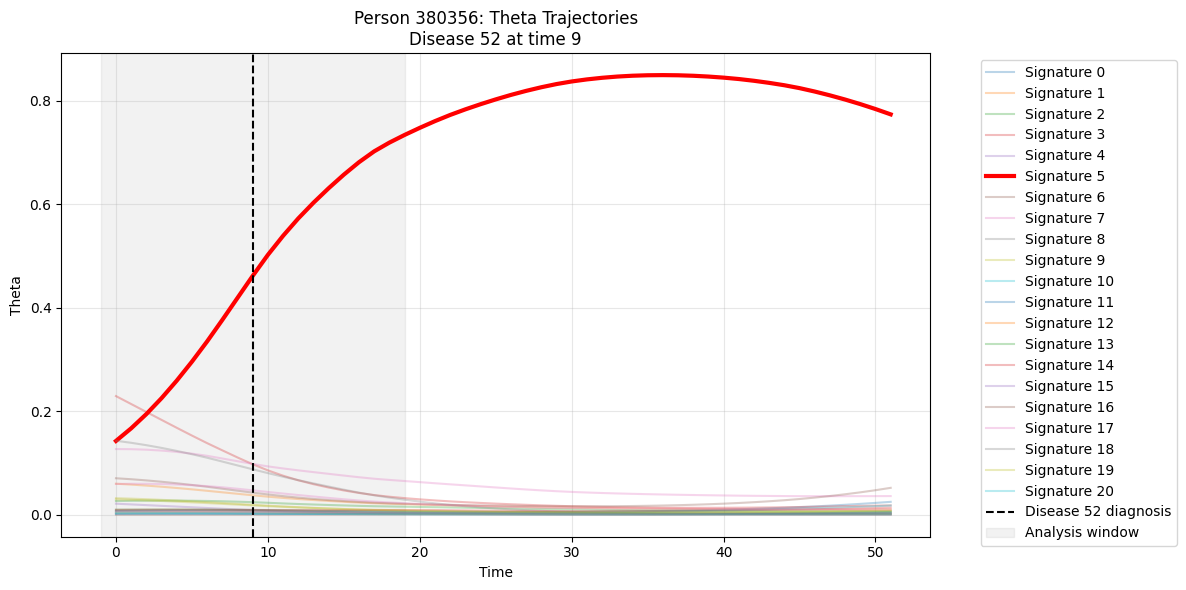

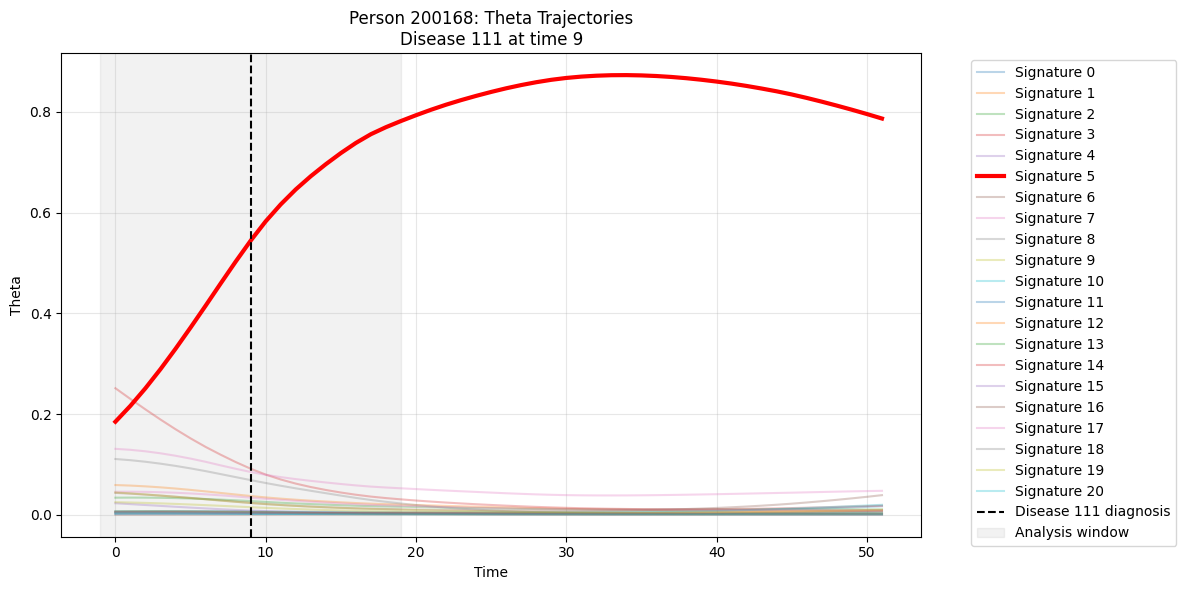

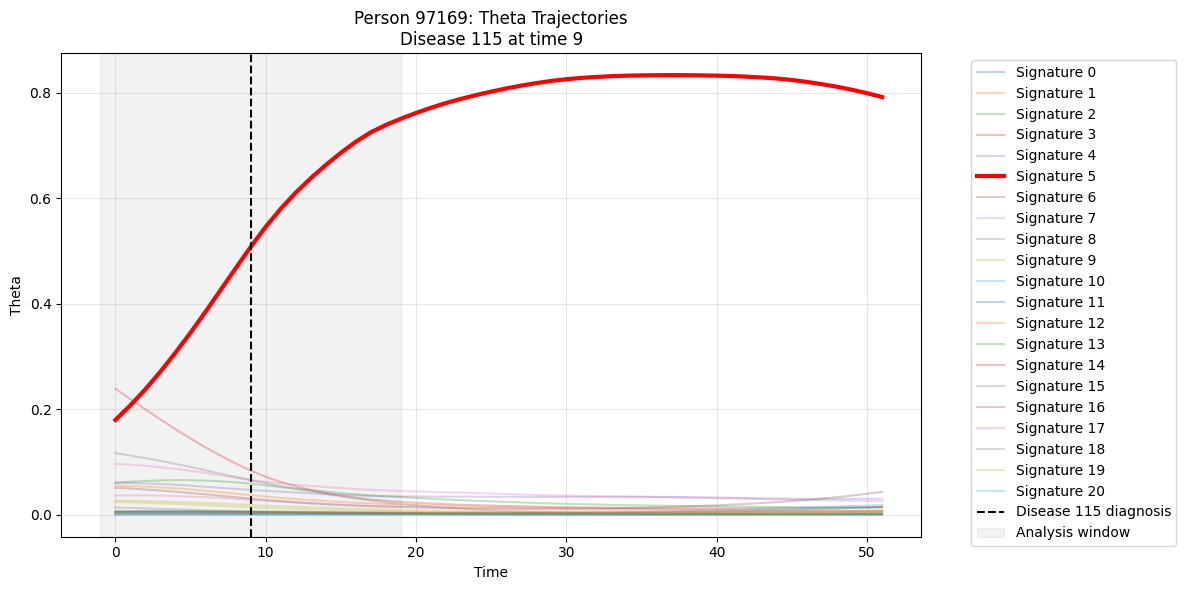

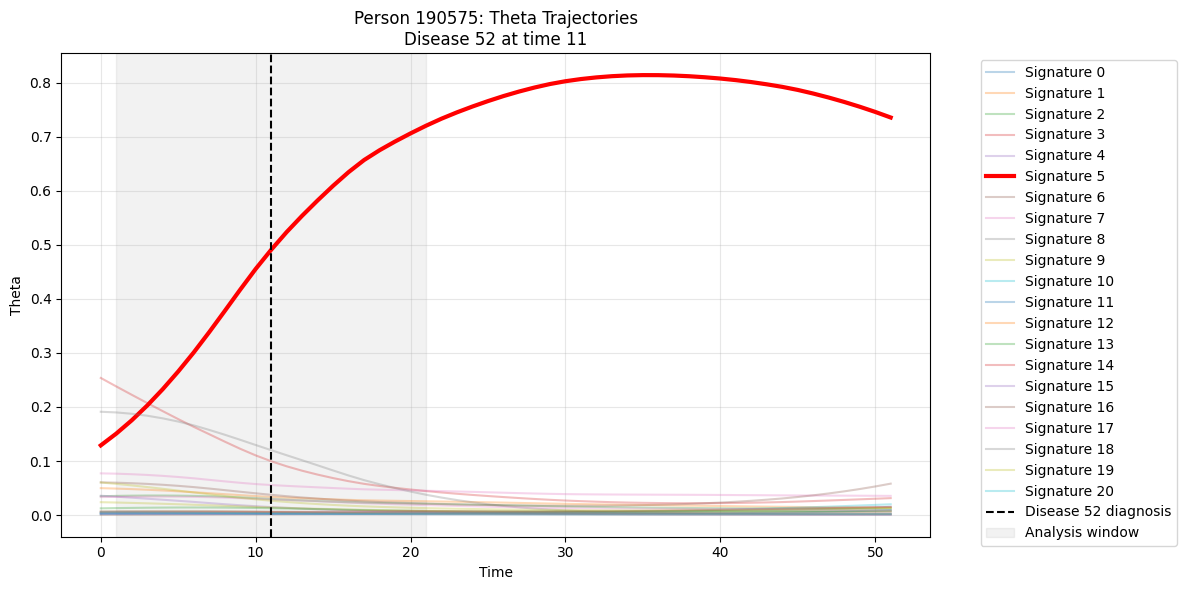

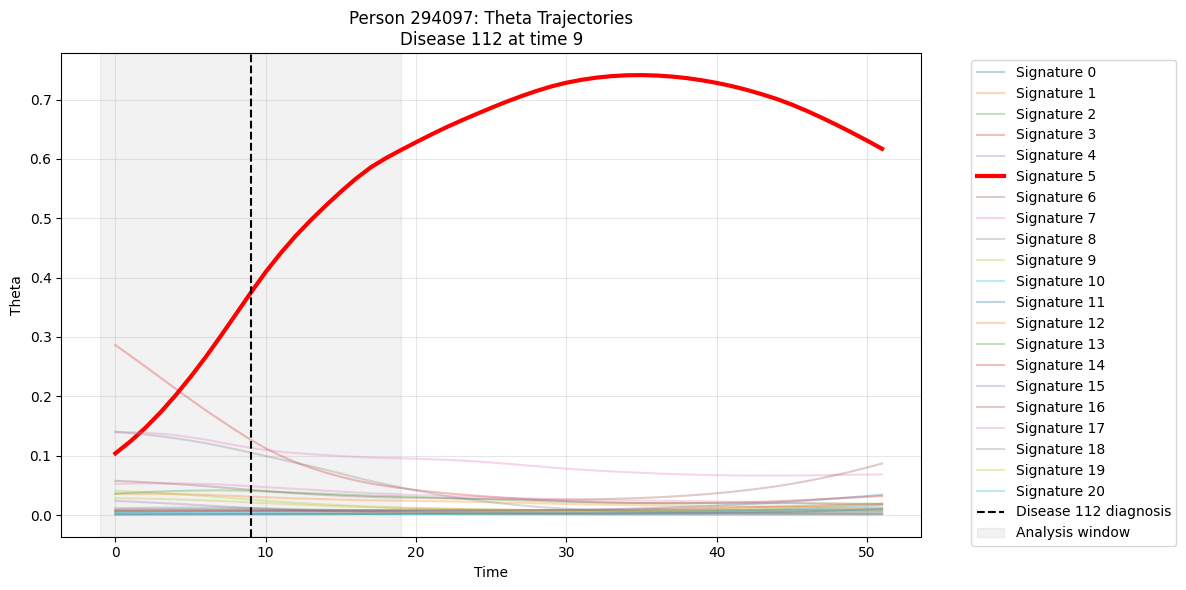

In [35]:
def plot_interesting_case(person_idx, disease_idx, time_idx, sig_idx, Y, all_thetas, window=10):
    plt.figure(figsize=(12, 6))
    
    # Plot all theta trajectories
    for k in range(all_thetas.shape[1]):  # Loop through all signatures
        if k == sig_idx:
            # Highlight the signature of interest
            plt.plot(all_thetas[person_idx, k, :], 
                    label=f'Signature {k}', 
                    linewidth=3, 
                    color='red')
        else:
            # Plot other signatures with lower opacity
            plt.plot(all_thetas[person_idx, k, :], 
                    label=f'Signature {k}', 
                    alpha=0.3)
    
    # Add vertical line for diagnosis
    plt.axvline(x=time_idx, color='black', linestyle='--', 
                label=f'Disease {disease_idx} diagnosis')
    
    # Add shaded region for the window we used
    plt.axvspan(time_idx-window, time_idx+window, 
                color='gray', alpha=0.1, 
                label='Analysis window')
    
    plt.title(f'Person {person_idx}: Theta Trajectories\nDisease {disease_idx} at time {time_idx}')
    plt.xlabel('Time')
    plt.ylabel('Theta')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Plot each interesting case
for case in examples[:5]:
    plot_interesting_case(
        case['person'], 
        case['disease'], 
        case['time'], 
        case['signature'],
        Y, 
        all_thetas
    )

In [36]:
disease_names[112]

np.str_('Myocardial infarction')

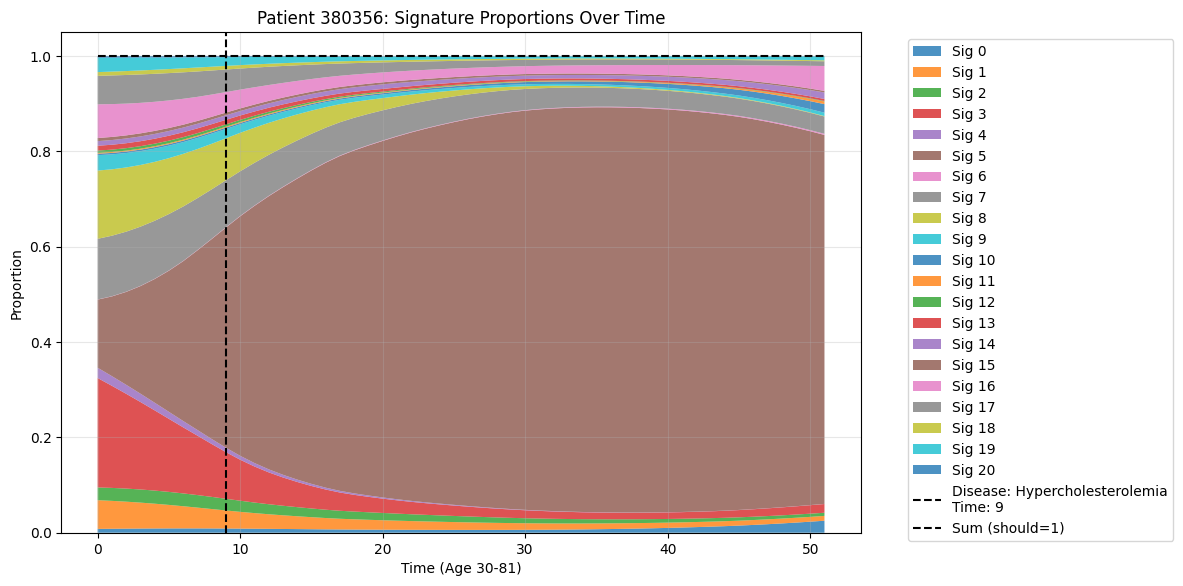

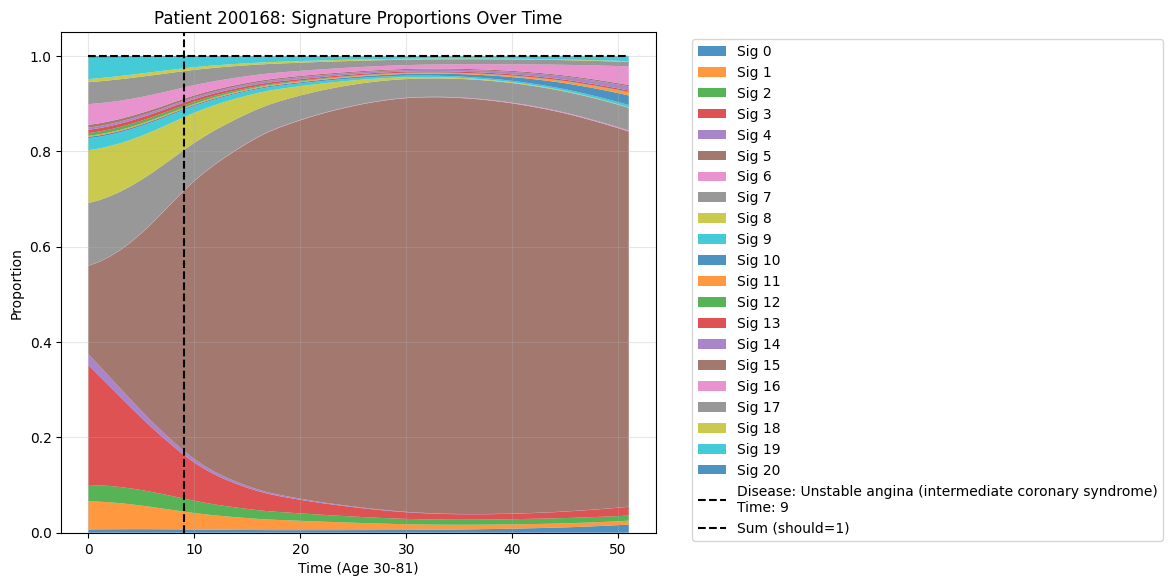

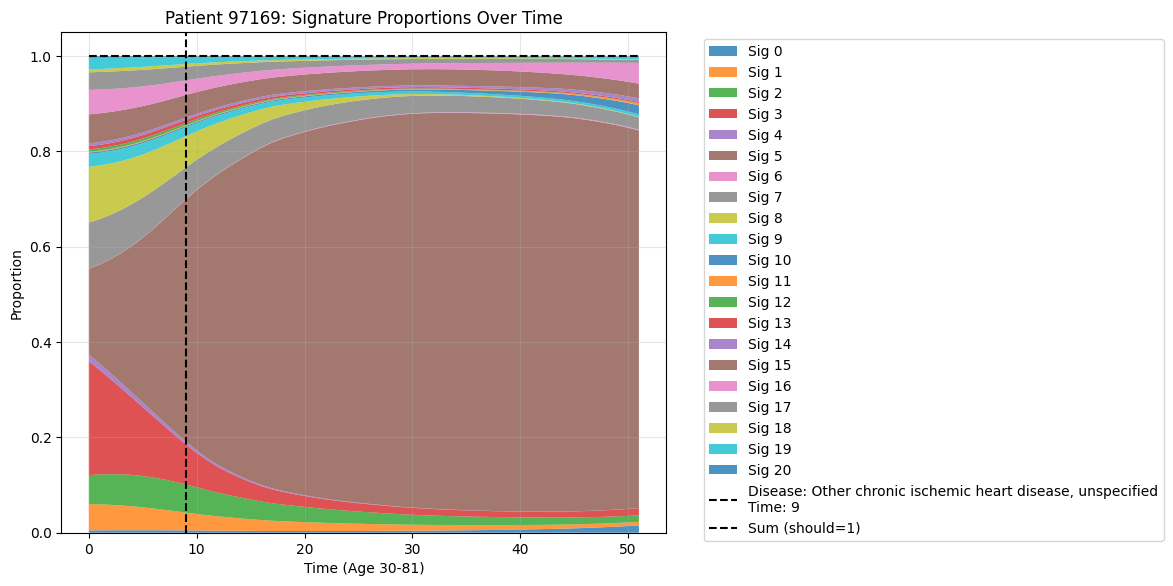

In [39]:
def plot_signature_proportions(person_idx, disease_idx, time_idx, Y, all_thetas, disease_names):
    plt.figure(figsize=(12, 6))
    
    # Create stacked area plot
    times = range(52)
    thetas = all_thetas[person_idx]  # Shape: (K, T)
    
    # Plot stacked areas
    plt.stackplot(times, thetas, 
                 labels=[f'Sig {k}' for k in range(len(thetas))],
                 alpha=0.8)
    
    # Add vertical line for diagnosis
    plt.axvline(x=time_idx, color='black', linestyle='--', 
                label=f'Disease: {disease_names[disease_idx]}\nTime: {time_idx}')
    
    # Add sum line to verify it equals 1
    plt.plot(times, np.sum(thetas, axis=0), 'k--', label='Sum (should=1)')
    
    plt.title(f'Patient {person_idx}: Signature Proportions Over Time')
    plt.xlabel('Time (Age 30-81)')
    plt.ylabel('Proportion')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Plot for each interesting case
for case in examples[:3]:  # Show first 3 cases
    plot_signature_proportions(
        case['person'], 
        case['disease'], 
        case['time'],
        Y, 
        all_thetas,
        disease_names
    )

/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_28551/565054179.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  exp_refs = np.exp(signature_refs)


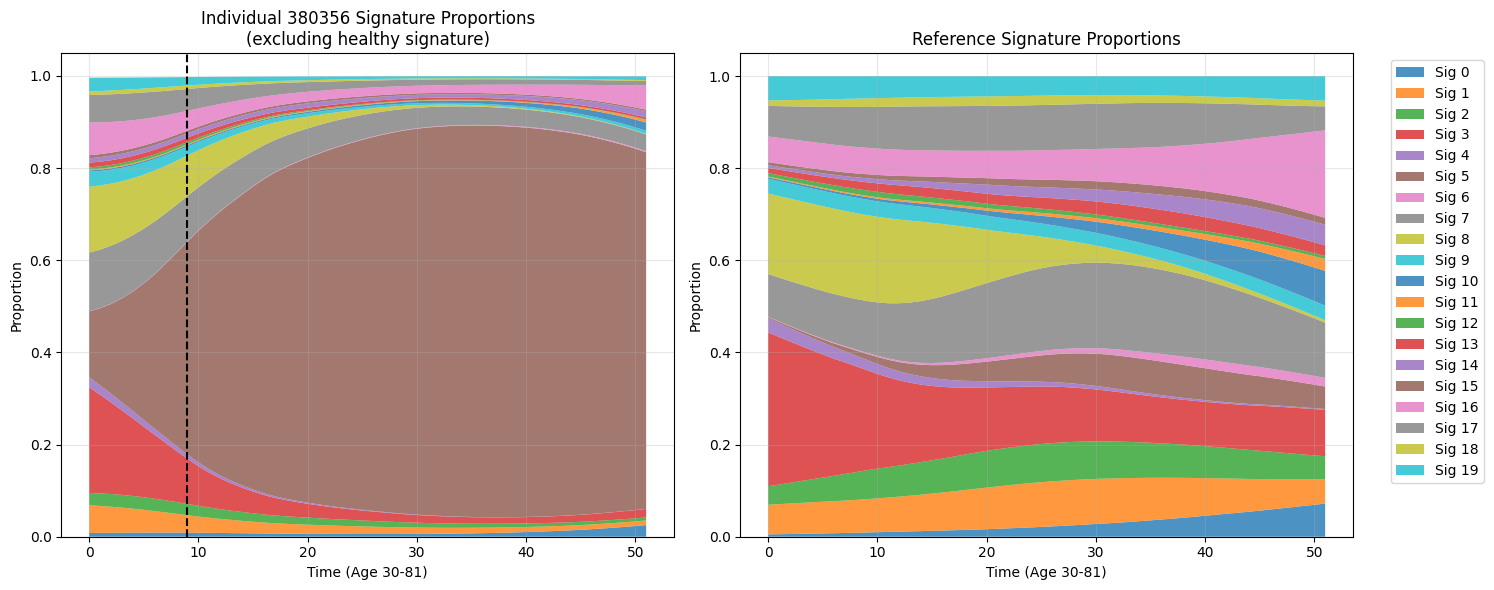

In [44]:
def convert_to_thetas(signature_refs):
    # Apply softmax to convert to proportions
    exp_refs = np.exp(signature_refs)
    return exp_refs / exp_refs.sum(axis=0, keepdims=True)

def plot_signature_comparison(person_idx, disease_idx, time_idx, all_thetas, signature_refs):
    plt.figure(figsize=(15, 6))
    
    # Individual's proportions
    plt.subplot(1, 2, 1)
    times = range(52)
    thetas = all_thetas[person_idx]  # Shape: (K, T)
    
    # Plot all signatures except healthy (last one)
    plt.stackplot(times, thetas[:-1], 
                 labels=[f'Sig {k}' for k in range(len(thetas)-1)],
                 alpha=0.8)
    
    plt.axvline(x=time_idx, color='black', linestyle='--', 
                label=f'Disease {disease_idx} diagnosis')
    
    plt.title(f'Individual {person_idx} Signature Proportions\n(excluding healthy signature)')
    plt.xlabel('Time (Age 30-81)')
    plt.ylabel('Proportion')
    plt.grid(True, alpha=0.3)
    
    # Reference signatures converted to thetas
    plt.subplot(1, 2, 2)
    ref_thetas = convert_to_thetas(signature_refs)
    plt.stackplot(times, ref_thetas,
                 labels=[f'Sig {k}' for k in range(ref_thetas.shape[0])],
                 alpha=0.8)
    
    plt.title('Reference Signature Proportions')
    plt.xlabel('Time (Age 30-81)')
    plt.ylabel('Proportion')
    plt.grid(True, alpha=0.3)
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Plot for first interesting case
case = examples[0]
plot_signature_comparison(
    case['person'], 
    case['disease'], 
    case['time'],
    all_thetas,
    signature_refs
)

/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_28551/565054179.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  exp_refs = np.exp(signature_refs)


Top 10 cases with largest deviations from reference:

Person 76310:
Disease 52 (Signature 5) at time 44
Deviation from reference: 0.864

Person 321461:
Disease 52 (Signature 5) at time 35
Deviation from reference: 0.859

Person 321461:
Disease 111 (Signature 5) at time 35
Deviation from reference: 0.859

Person 321461:
Disease 113 (Signature 5) at time 35
Deviation from reference: 0.859

Person 321461:
Disease 114 (Signature 5) at time 35
Deviation from reference: 0.859

Person 321461:
Disease 115 (Signature 5) at time 35
Deviation from reference: 0.859

Person 126303:
Disease 112 (Signature 5) at time 30
Deviation from reference: 0.857

Person 321461:
Disease 112 (Signature 5) at time 27
Deviation from reference: 0.856

Person 123403:
Disease 113 (Signature 5) at time 32
Deviation from reference: 0.855

Person 123403:
Disease 115 (Signature 5) at time 31
Deviation from reference: 0.854


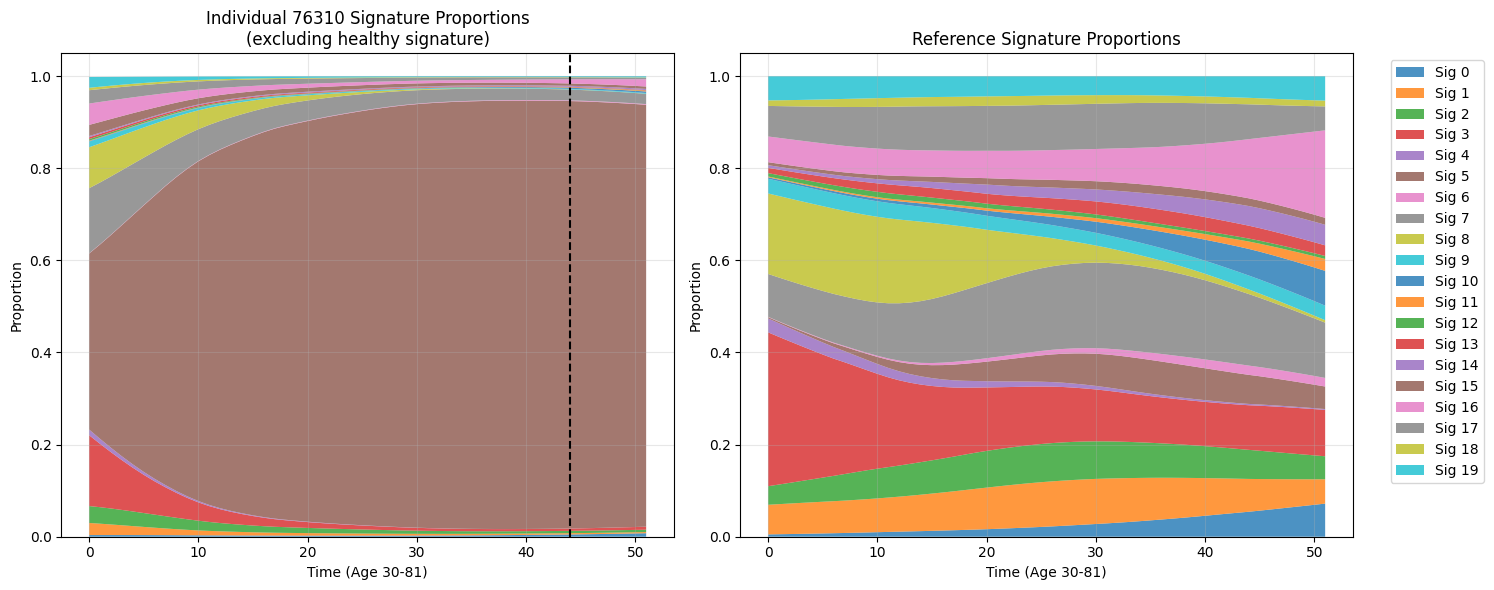

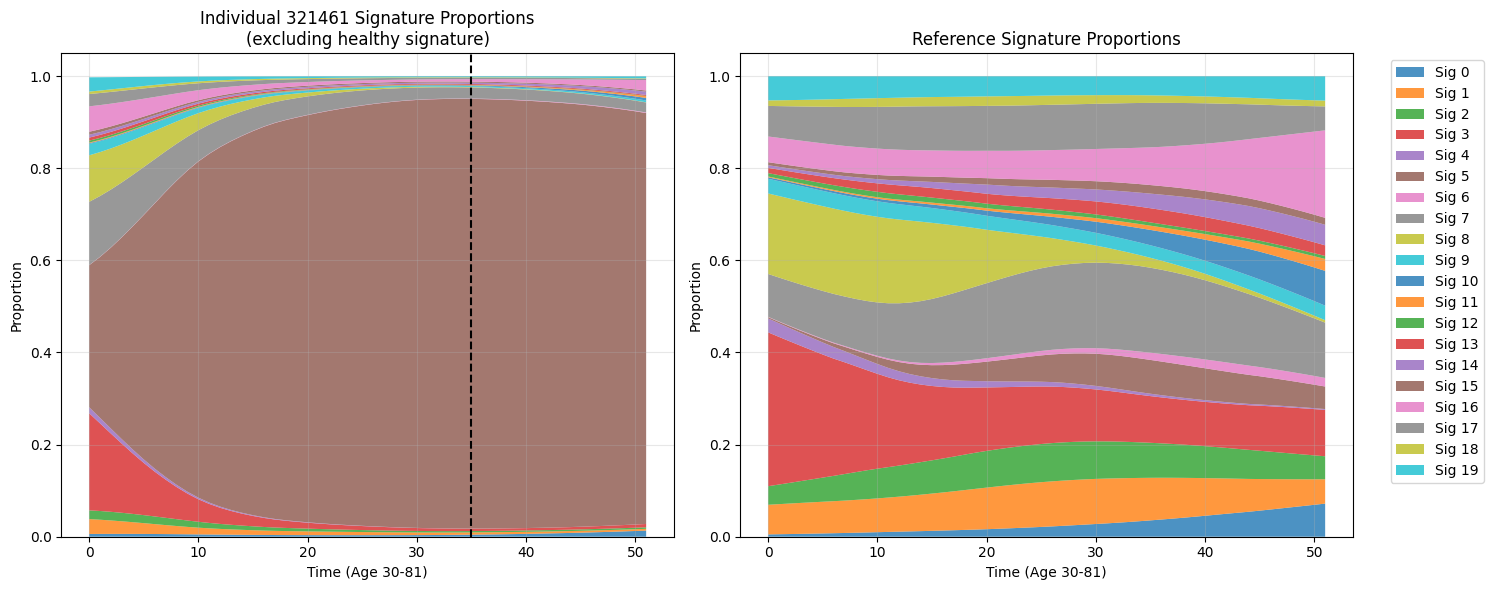

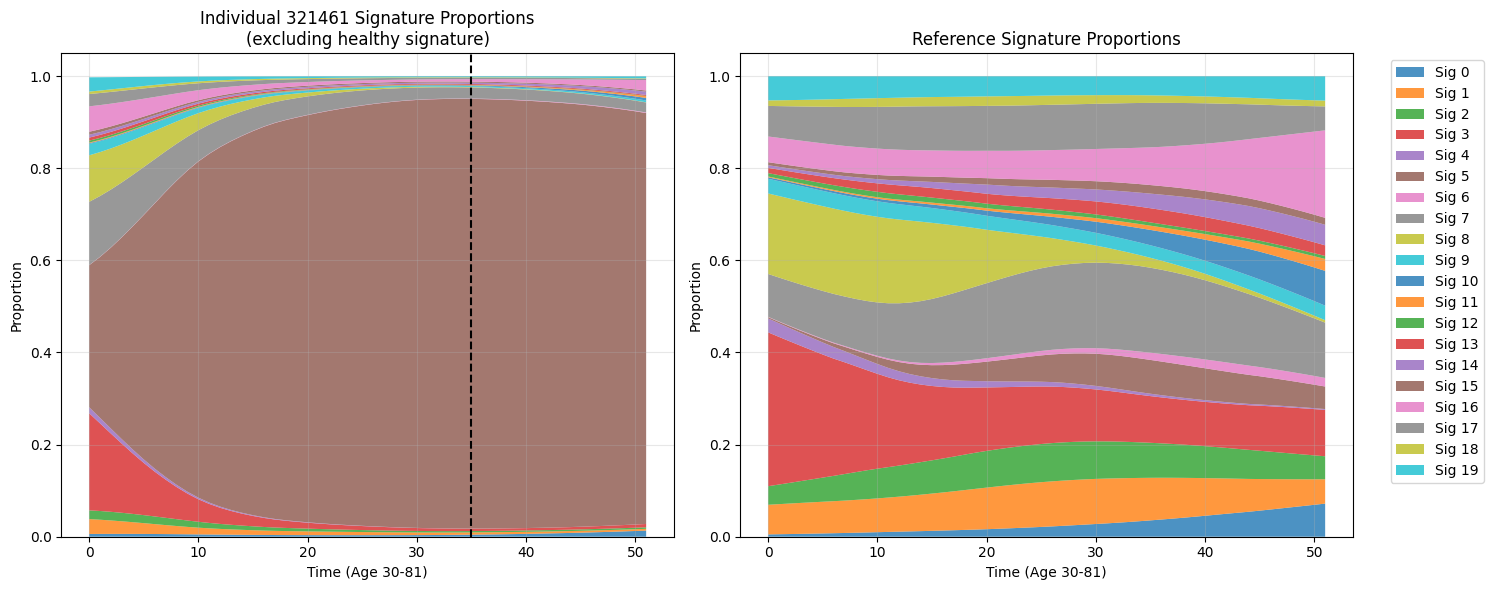

In [47]:
def calculate_deviation_index(Y, all_thetas, signature_refs, cluster_ids, window=5):
    deviations = []
    ref_thetas = convert_to_thetas(signature_refs)
    
    # Convert to numpy if they're tensors
    if torch.is_tensor(ref_thetas):
        ref_thetas = ref_thetas.numpy()
    if torch.is_tensor(all_thetas):
        all_thetas = all_thetas.numpy()
    if torch.is_tensor(Y):
        Y = Y.numpy()
    if torch.is_tensor(cluster_ids):
        cluster_ids = cluster_ids.numpy()
    
    # For each person
    for i in range(len(all_thetas)):
        # Find their diagnoses
        diseases = np.where(Y[i].sum(axis=1) > 0)[0]
        
        if len(diseases) > 0:
            for d in diseases:
                t = np.where(Y[i, d] == 1)[0][0]
                sig = cluster_ids[d].item() if hasattr(cluster_ids[d], 'item') else cluster_ids[d]
                
                if t > window and t < (52-window):
                    # Get person's theta trajectory for this signature
                    person_theta = all_thetas[i, sig, t-window:t+window]
                    # Get reference trajectory for same period
                    ref_theta = ref_thetas[sig, t-window:t+window]
                    
                    # Calculate deviation
                    deviation = np.mean(np.abs(person_theta - ref_theta))
                    
                    deviations.append({
                        'person': i,
                        'disease': d,
                        'time': t,
                        'signature': sig,
                        'deviation': deviation
                    })
    
    # Sort by deviation
    deviations.sort(key=lambda x: x['deviation'], reverse=True)
    return deviations

# Calculate deviations
deviations = calculate_deviation_index(Y, all_thetas, signature_refs, cluster_ids)

# Print top 10 most deviant cases
print("Top 10 cases with largest deviations from reference:")
for d in deviations[:10]:
    print(f"\nPerson {d['person']}:")
    print(f"Disease {d['disease']} (Signature {d['signature']}) at time {d['time']}")
    print(f"Deviation from reference: {d['deviation']:.3f}")
    
# Plot a few of these cases
for d in deviations[:3]:
    plot_signature_comparison(
        d['person'],
        d['disease'],
        d['time'],
        all_thetas,
        signature_refs
    )

/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_28551/565054179.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  exp_refs = np.exp(signature_refs)


Top cases with early signature changes:

Person 200168:
Disease 115 (Signature 5) at time 13
Pre-diagnosis deviation: 0.465
Rate of change: 0.036

Person 330140:
Disease 52 (Signature 5) at time 15
Pre-diagnosis deviation: 0.484
Rate of change: 0.034

Person 330140:
Disease 112 (Signature 5) at time 15
Pre-diagnosis deviation: 0.484
Rate of change: 0.034

Person 330140:
Disease 114 (Signature 5) at time 15
Pre-diagnosis deviation: 0.484
Rate of change: 0.034

Person 67045:
Disease 112 (Signature 5) at time 15
Pre-diagnosis deviation: 0.483
Rate of change: 0.033


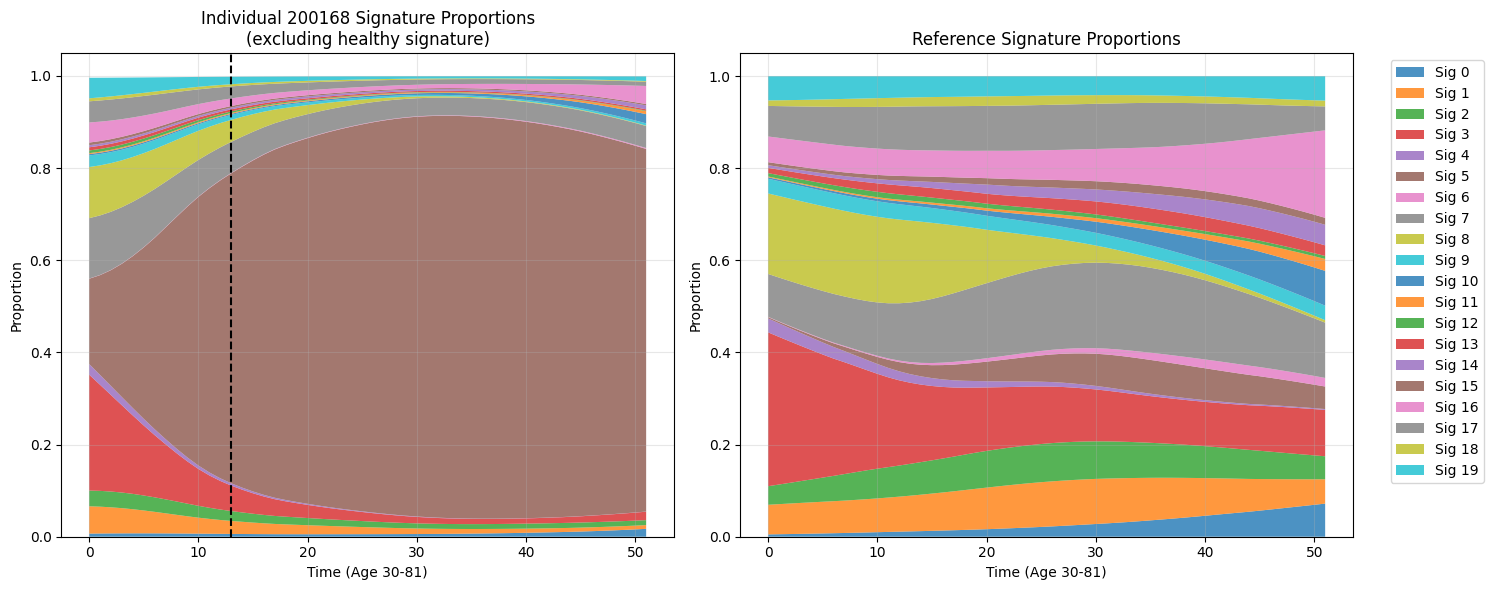

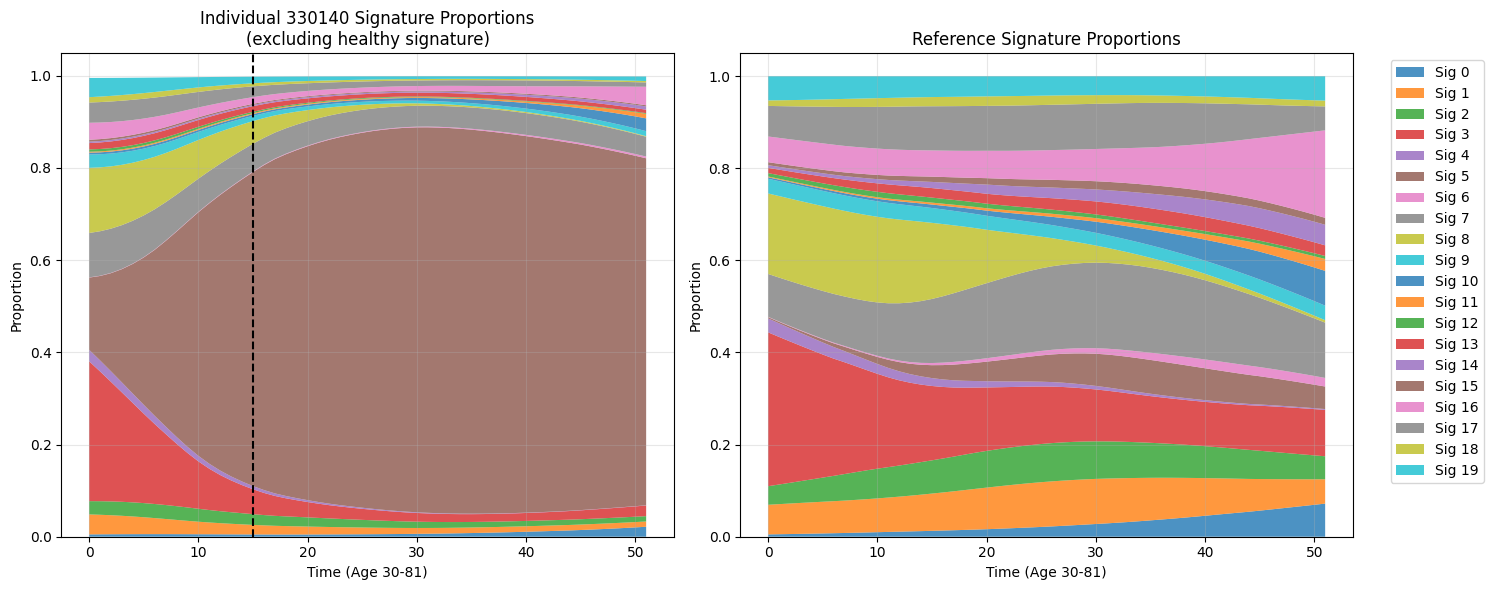

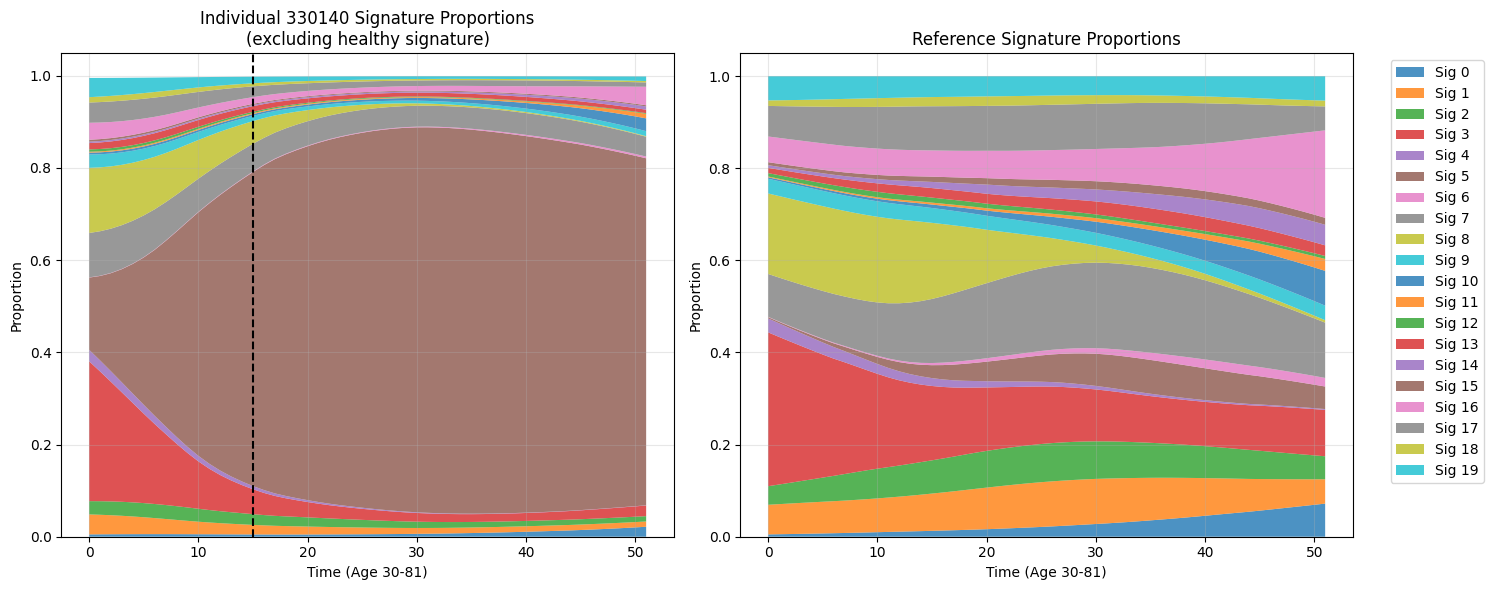

In [48]:
def analyze_predictive_deviation(Y, all_thetas, signature_refs, cluster_ids, pre_window=10, post_window=5):
    predictive_cases = []
    ref_thetas = convert_to_thetas(signature_refs)
    
    # Convert to numpy if needed
    if torch.is_tensor(ref_thetas):
        ref_thetas = ref_thetas.numpy()
    if torch.is_tensor(all_thetas):
        all_thetas = all_thetas.numpy()
    if torch.is_tensor(Y):
        Y = Y.numpy()
    if torch.is_tensor(cluster_ids):
        cluster_ids = cluster_ids.numpy()
    
    for i in range(len(all_thetas)):
        diseases = np.where(Y[i].sum(axis=1) > 0)[0]
        
        for d in diseases:
            t = np.where(Y[i, d] == 1)[0][0]
            sig = cluster_ids[d].item() if hasattr(cluster_ids[d], 'item') else cluster_ids[d]
            
            if t > pre_window:  # Ensure we can look back far enough
                # Calculate deviation in pre-diagnosis window
                pre_person = all_thetas[i, sig, t-pre_window:t]
                pre_ref = ref_thetas[sig, t-pre_window:t]
                pre_deviation = np.mean(np.abs(pre_person - pre_ref))
                
                # Calculate rate of change in signature proportion
                slope = (pre_person[-1] - pre_person[0]) / pre_window
                
                predictive_cases.append({
                    'person': i,
                    'disease': d,
                    'time': t,
                    'signature': sig,
                    'pre_deviation': pre_deviation,
                    'slope': slope
                })
    
    # Sort by pre-diagnosis deviation
    predictive_cases.sort(key=lambda x: abs(x['slope']), reverse=True)
    return predictive_cases

# Find cases with strong predictive patterns
predictive_cases = analyze_predictive_deviation(Y, all_thetas, signature_refs, cluster_ids)

# Print top cases
print("Top cases with early signature changes:")
for case in predictive_cases[:5]:
    print(f"\nPerson {case['person']}:")
    print(f"Disease {case['disease']} (Signature {case['signature']}) at time {case['time']}")
    print(f"Pre-diagnosis deviation: {case['pre_deviation']:.3f}")
    print(f"Rate of change: {case['slope']:.3f}")
    
# Plot these cases
for case in predictive_cases[:3]:
    plot_signature_comparison(
        case['person'],
        case['disease'],
        case['time'],
        all_thetas,
        signature_refs
    )

In [50]:
def analyze_predictive_power(Y, all_thetas, signature_refs, cluster_ids, pre_window=10):
    ref_thetas = convert_to_thetas(signature_refs)
    results = {sig: {'predictive': 0, 'non_predictive': 0} for sig in range(20)}
    
    # Convert to numpy if needed
    if torch.is_tensor(ref_thetas):
        ref_thetas = ref_thetas.numpy()
    if torch.is_tensor(all_thetas):
        all_thetas = all_thetas.numpy()
    if torch.is_tensor(Y):
        Y = Y.numpy()
    if torch.is_tensor(cluster_ids):
        cluster_ids = cluster_ids.numpy()
    
    for i in range(len(all_thetas)):
        diseases = np.where(Y[i].sum(axis=1) > 0)[0]
        
        for d in diseases:
            t = np.where(Y[i, d] == 1)[0][0]
            sig = cluster_ids[d].item() if hasattr(cluster_ids[d], 'item') else cluster_ids[d]
            
            if t > pre_window:
                # Get signature proportions before diagnosis
                person_props = all_thetas[i, sig, t-pre_window:t]
                ref_props = ref_thetas[sig, t-pre_window:t]
                
                # Calculate trend
                person_trend = person_props[-1] - person_props[0]
                ref_trend = ref_props[-1] - ref_props[0]
                
                # Compare to reference at diagnosis
                if person_props[-1] > ref_props[-1] and person_trend > ref_trend:
                    results[sig]['predictive'] += 1
                else:
                    results[sig]['non_predictive'] += 1
    
    # Calculate predictive power for each signature
    print("\nPredictive power by signature:")
    for sig in results:
        total = results[sig]['predictive'] + results[sig]['non_predictive']
        if total > 0:
            pred_power = results[sig]['predictive'] / total
            print(f"\nSignature {sig}:")
            print(f"Total cases: {total}")
            print(f"Predictive cases: {results[sig]['predictive']}")
            print(f"Predictive power: {pred_power:.2%}")
    
    return results

# Run analysis
predictive_power = analyze_predictive_power(Y, all_thetas, signature_refs, cluster_ids)

/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_28551/565054179.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  exp_refs = np.exp(signature_refs)



Predictive power by signature:

Signature 0:
Total cases: 124878
Predictive cases: 43465
Predictive power: 34.81%

Signature 1:
Total cases: 267684
Predictive cases: 61224
Predictive power: 22.87%

Signature 2:
Total cases: 231590
Predictive cases: 51800
Predictive power: 22.37%

Signature 3:
Total cases: 334883
Predictive cases: 65018
Predictive power: 19.42%

Signature 4:
Total cases: 22020
Predictive cases: 2510
Predictive power: 11.40%

Signature 5:
Total cases: 203072
Predictive cases: 92774
Predictive power: 45.69%

Signature 6:
Total cases: 51186
Predictive cases: 21452
Predictive power: 41.91%

Signature 7:
Total cases: 492131
Predictive cases: 109649
Predictive power: 22.28%

Signature 8:
Total cases: 122723
Predictive cases: 16545
Predictive power: 13.48%

Signature 9:
Total cases: 96747
Predictive cases: 22933
Predictive power: 23.70%

Signature 10:
Total cases: 121408
Predictive cases: 51769
Predictive power: 42.64%

Signature 11:
Total cases: 37204
Predictive cases: 12956

In [52]:
def analyze_by_disease_count(Y, all_thetas, signature_refs, cluster_ids):
    ref_thetas = convert_to_thetas(signature_refs)
    results = {sig: {n: {'count': 0, 'higher_than_ref': 0} for n in range(1, 6)} for sig in range(20)}
    
    # For each person
    for i in range(len(all_thetas)):
        # Count diseases per signature
        sig_disease_counts = {}
        diseases = np.where(Y[i].sum(axis=1) > 0)[0]
        
        for d in diseases:
            sig = cluster_ids[d].item()
            sig_disease_counts[sig] = sig_disease_counts.get(sig, 0) + 1
        
        # Compare proportions based on disease count
        for sig, count in sig_disease_counts.items():
            if count <= 5:  # Cap at 5+ diseases
                results[sig][count]['count'] += 1
                if all_thetas[i, sig].mean() > ref_thetas[sig].mean():
                    results[sig][count]['higher_than_ref'] += 1
    
    # Print results
    print("\nAnalysis by number of diseases per signature:")
    for sig in sorted(results.keys()):
        print(f"\nSignature {sig}:")
        for n_diseases in range(1, 6):
            data = results[sig][n_diseases]
            if data['count'] > 0:
                success_rate = data['higher_than_ref'] / data['count']
                print(f"{n_diseases} disease(s): {data['count']} people, {success_rate:.2%} higher than ref")

# Run analysis
analyze_by_disease_count(Y, all_thetas, signature_refs, cluster_ids)

/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_28551/565054179.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  exp_refs = np.exp(signature_refs)



Analysis by number of diseases per signature:

Signature 0:
1 disease(s): 36636 people, 40.55% higher than ref
2 disease(s): 12557 people, 42.44% higher than ref
3 disease(s): 6205 people, 43.42% higher than ref
4 disease(s): 3696 people, 44.99% higher than ref
5 disease(s): 2187 people, 47.92% higher than ref

Signature 1:
1 disease(s): 77512 people, 40.80% higher than ref
2 disease(s): 37290 people, 42.66% higher than ref
3 disease(s): 17484 people, 43.18% higher than ref
4 disease(s): 8023 people, 45.41% higher than ref
5 disease(s): 3478 people, 49.28% higher than ref

Signature 2:
1 disease(s): 44477 people, 40.36% higher than ref
2 disease(s): 28017 people, 41.13% higher than ref
3 disease(s): 16356 people, 43.43% higher than ref
4 disease(s): 8854 people, 45.10% higher than ref
5 disease(s): 4580 people, 47.07% higher than ref

Signature 3:
1 disease(s): 119753 people, 39.87% higher than ref
2 disease(s): 49402 people, 38.42% higher than ref
3 disease(s): 20222 people, 37.17% h

In [59]:
def analyze_by_disease_count_and_time(Y, all_thetas, signature_refs, cluster_ids, 
                                    pre_window=10, post_window=5):
    # Convert signature_refs to numpy and apply softmax
    if torch.is_tensor(signature_refs):
        signature_refs = signature_refs.numpy()
    ref_thetas = np.exp(signature_refs) / np.exp(signature_refs).sum(axis=0)
    
    # Convert other inputs if needed
    if torch.is_tensor(Y):
        Y = Y.numpy()
    if torch.is_tensor(cluster_ids):
        cluster_ids = cluster_ids.numpy()
    
    results = {sig: {n: {'count': 0, 
                        'higher_before': 0,
                        'higher_at': 0,
                        'higher_after': 0} 
                    for n in range(1, 6)} for sig in range(20)}
    
    for i in range(len(all_thetas)):
        # Count diseases per signature
        sig_disease_counts = {}
        diseases = np.where(Y[i].sum(axis=1) > 0)[0]
        
        for d in diseases:
            t = np.where(Y[i, d] == 1)[0][0]
            sig = cluster_ids[d]
            sig_disease_counts[sig] = sig_disease_counts.get(sig, 0) + 1
            
            if t > pre_window and t < (52 - post_window):
                count = sig_disease_counts[sig]
                if count <= 5:
                    results[sig][count]['count'] += 1
                    
                    # Check before diagnosis
                    before_props = all_thetas[i, sig, t-pre_window:t]
                    before_refs = ref_thetas[sig, t-pre_window:t]
                    if np.mean(before_props > before_refs) > 0.5:
                        results[sig][count]['higher_before'] += 1
                    
                    # At diagnosis
                    if all_thetas[i, sig, t] > ref_thetas[sig, t]:
                        results[sig][count]['higher_at'] += 1
                    
                    # After diagnosis
                    after_props = all_thetas[i, sig, t:t+post_window]
                    after_refs = ref_thetas[sig, t:t+post_window]
                    if np.mean(after_props > after_refs) > 0.5:
                        results[sig][count]['higher_after'] += 1
    
    # Print results for all signatures
    for sig in range(20):
        print(f"\nSignature {sig}:")
        for n_diseases in range(1, 6):
            data = results[sig][n_diseases]
            if data['count'] > 0:
                before_rate = data['higher_before'] / data['count']
                at_rate = data['higher_at'] / data['count']
                after_rate = data['higher_after'] / data['count']
                print(f"{n_diseases} disease(s): {data['count']} people")
                print(f"  Higher before diagnosis: {before_rate:.2%}")
                print(f"  Higher at diagnosis: {at_rate:.2%}")
                print(f"  Higher after diagnosis: {after_rate:.2%}")

# Run temporal analysis
analyze_by_disease_count_and_time(Y, all_thetas, signature_refs, cluster_ids)


Signature 0:
1 disease(s): 54369 people
  Higher before diagnosis: 41.06%
  Higher at diagnosis: 41.14%
  Higher after diagnosis: 41.18%
2 disease(s): 22689 people
  Higher before diagnosis: 42.24%
  Higher at diagnosis: 42.46%
  Higher after diagnosis: 42.76%
3 disease(s): 12209 people
  Higher before diagnosis: 43.93%
  Higher at diagnosis: 44.21%
  Higher after diagnosis: 44.37%
4 disease(s): 7098 people
  Higher before diagnosis: 44.90%
  Higher at diagnosis: 45.00%
  Higher after diagnosis: 45.41%
5 disease(s): 4085 people
  Higher before diagnosis: 45.80%
  Higher at diagnosis: 46.00%
  Higher after diagnosis: 46.19%

Signature 1:
1 disease(s): 133251 people
  Higher before diagnosis: 41.16%
  Higher at diagnosis: 41.56%
  Higher after diagnosis: 41.47%
2 disease(s): 63679 people
  Higher before diagnosis: 42.37%
  Higher at diagnosis: 42.67%
  Higher after diagnosis: 42.65%
3 disease(s): 29432 people
  Higher before diagnosis: 43.45%
  Higher at diagnosis: 43.50%
  Higher after

In [67]:
# Load the model
first_model = torch.load('/Users/sarahurbut/Dropbox (Personal)/from_AWS/resultstraj/output_0_10000/model.pt')

# Extract key components
phi = first_model['model_state_dict']['phi']
psi = first_model['model_state_dict']['psi']
logit_prev = first_model['logit_prevalence_t']

print("\nChecking values for a few example diseases:")
for k in [0, 5, 10]:  # Check signatures 0, 5, and 10
    print(f"\nSignature {k}:")
    # Get diseases in this cluster
    cluster_mask = (first_model['clusters'] == k)
    cluster_diseases = np.array(essentials['disease_names'])[cluster_mask]
    
    # Print first 3 diseases in cluster
    for d_name in cluster_diseases[:3]:
        d_idx = essentials['disease_names'].index(d_name)
        print(f"\nDisease: {d_name}")
        print(f"Baseline prevalence logit: {logit_prev[d_idx, 0]:.3f}")  # First timepoint
        print(f"Psi: {psi[k, d_idx]:.3f}")
        print(f"Phi mean: {phi[k, d_idx].mean():.3f}")


Checking values for a few example diseases:

Signature 0:

Disease: Rheumatic disease of the heart valves
Baseline prevalence logit: -16.790
Psi: 0.873
Phi mean: -9.948

Disease: Mitral valve disease
Baseline prevalence logit: -13.146
Psi: 0.974
Phi mean: -8.065

Disease: Aortic valve disease
Baseline prevalence logit: -14.789
Psi: 1.179
Phi mean: -8.793

Signature 5:

Disease: Hypercholesterolemia
Baseline prevalence logit: -12.374
Psi: 1.079
Phi mean: -5.892

Disease: Unstable angina (intermediate coronary syndrome)
Baseline prevalence logit: -14.611
Psi: 0.816
Phi mean: -8.185

Disease: Myocardial infarction
Baseline prevalence logit: -13.404
Psi: 0.860
Phi mean: -7.140

Signature 10:

Disease: Retinal detachments and defects
Baseline prevalence logit: -12.860
Psi: 0.833
Phi mean: -8.746

Disease: Retinal detachment with retinal defect
Baseline prevalence logit: -12.332
Psi: 0.795
Phi mean: -8.804

Disease: Other retinal disorders
Baseline prevalence logit: -16.736
Psi: 1.113
Phi m

/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_28551/2102883623.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  first_model = torch.load('/Users/sarahurbut/D

In [73]:
Y.shape


torch.Size([407878, 348, 52])

In [85]:
checkpoint = torch.load('/Users/sarahurbut/Dropbox (Personal)/from_AWS/resultstraj/output_0_10000/model.pt')
checkpoint['psi']

/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_28551/347197278.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/Users/sarahurbut/Dro

Parameter containing:
tensor([[-2.0078, -1.9824, -2.0043,  ..., -1.9997, -1.9802, -2.0136],
        [-1.9952, -1.9690, -1.9960,  ..., -2.0071, -1.9960, -1.9912],
        [-1.9826, -1.9807, -2.0075,  ..., -2.0019, -1.9873, -2.0008],
        ...,
        [-1.9943, -2.0009, -1.9819,  ..., -1.9749, -2.0113, -2.0082],
        [-1.9980, -1.9918, -1.9897,  ..., -1.9871, -2.0033, -1.9954],
        [-5.0030, -5.0041, -5.0104,  ..., -5.0064, -4.9999, -5.0015]],
       requires_grad=True)

In [23]:
def get_signature_diseases(sig_num, effects_threshold=0):
    """
    Get indices of diseases that belong to a signature based on their effects
    
    sig_num: signature number
    effects_threshold: minimum effect size to consider (0 for positive effects only)
    """
    # This should be loaded once outside the function
    checkpoint = torch.load('/Users/sarahurbut/Dropbox (Personal)/from_AWS/resultstraj/output_0_10000/model.pt')
    psi = checkpoint['psi']  # Shape should be (n_diseases, n_signatures)
   
    # Get diseases with positive effects in this signature
    sig_diseases = torch.where(psi[:, sig_num] > effects_threshold)[0]
    
    return sig_diseases


In [21]:
def analyze_transitions(E, pi_pred, window_years=[-5, -2, -1, -0.5, 0]):
    """
    Analyze signature probabilities before first diagnosis
    
    E: events matrix (n_people, n_diseases) with diagnosis times - torch tensor
    pi_pred: predicted probabilities (n_people, n_diseases, n_timepoints) - torch tensor
    window_years: years before first diagnosis to analyze
    """
    
    # Get first diagnosis time for each person
    first_dx = torch.min(E, dim=1).values
    
    # Convert years to timepoints (assuming monthly data)
    timesteps_per_year = 12  
    windows = [int(year * timesteps_per_year) for year in window_years]
    
    n_signatures = 20
    results = {}
    
    for sig in range(n_signatures):
        sig_diseases = get_signature_diseases(sig)
        
        sig_results = []
        for window in windows:
            probs = []
            for person in range(len(first_dx)):
                dx_time = first_dx[person].item()  # Convert to Python scalar for indexing
                if dx_time > abs(window):
                    # Convert window index to tensor and ensure it's within bounds
                    time_idx = min(max(0, int(dx_time + window)), pi_pred.shape[2]-1)
                    # Index the tensor and take mean
                    prob_at_window = torch.mean(pi_pred[person, sig_diseases, time_idx])
                    probs.append(prob_at_window.item())
            
            mean_prob = sum(probs) / len(probs) if probs else 0
            sig_results.append({
                'years_before_dx': window/timesteps_per_year,
                'mean_prob': mean_prob,
                'n_people': len(probs)
            })
            
        results[sig] = sig_results
    
    return results

In [24]:
def analyze_transitions(E, pi_pred, window_years=[-5, -2, -1, -0.5, 0]):
    """
    Analyze signature probabilities before first diagnosis
    """
    # Take first 400K from E to match pi_pred
    E = E[:400000]
    
    # Convert pi_pred to tensor if it's not already
    pi_pred = torch.tensor(pi_pred)
    
    # Get first diagnosis time for each person
    first_dx = torch.min(E, dim=1).values
    
    # Convert years to timepoints (assuming monthly data)
    timesteps_per_year = 12  
    windows = [int(year * timesteps_per_year) for year in window_years]
    
    n_signatures = 20
    results = {}
    
    for sig in range(n_signatures):
        sig_diseases = get_signature_diseases(sig)
        
        sig_results = []
        for window in windows:
            probs = []
            for person in range(len(first_dx)):
                dx_time = first_dx[person].item()
                if dx_time > abs(window):
                    time_idx = min(max(0, int(dx_time + window)), pi_pred.shape[2]-1)
                    slice_data = pi_pred[person, sig_diseases, time_idx]
                    if len(slice_data.shape) > 0:
                        prob_at_window = torch.mean(slice_data)
                    else:
                        prob_at_window = slice_data
                    probs.append(prob_at_window.item())
            
            mean_prob = sum(probs) / len(probs) if probs else 0
            sig_results.append({
                'years_before_dx': window/timesteps_per_year,
                'mean_prob': mean_prob,
                'n_people': len(probs)
            })
        
        results[sig] = sig_results
    
    return results

# Try running with:
results = analyze_transitions(E, pi_pred)

: 

In [11]:
def analyze_disease_progression(Y, all_thetas, phi_prob, disease1='CAD', disease2='Colon cancer', 
                              window_years=[-5, -2, -1, -0.5, 0], batch_size=1000):
    """
    Analyze if people who got disease1 (e.g. CAD) first showed elevated signatures
    for disease2 (e.g. Colon cancer) before their disease2 diagnosis
    """
    # Get disease indices
    d1_idx = disease_names.index(disease1)
    d2_idx = disease_names.index(disease2)
    
    # Find signature for disease2
    d2_sig = cluster_ids[d2_idx].item()
    
    # Find people who got disease1 before disease2
    progression_cases = []
    for i in range(len(Y)):
        if Y[i, d1_idx].sum() > 0 and Y[i, d2_idx].sum() > 0:  # Has both diseases
            t1 = np.where(Y[i, d1_idx] == 1)[0][0]  # Time of first disease
            t2 = np.where(Y[i, d2_idx] == 1)[0][0]  # Time of second disease
            if t1 < t2:  # Got disease1 before disease2
                progression_cases.append({
                    'person': i,
                    'time_d1': t1,
                    'time_d2': t2
                })
    
    print(f"Found {len(progression_cases)} people who got {disease1} before {disease2}")
    
    # Analyze their signature trajectories
    results = []
    timesteps_per_year = 12
    windows = [int(year * timesteps_per_year) for year in window_years]
    
    # Process in batches
    for batch_start in range(0, len(progression_cases), batch_size):
        batch_cases = progression_cases[batch_start:batch_start + batch_size]
        batch_indices = [case['person'] for case in batch_cases]
        
        # Calculate predictions for this batch
        batch_thetas = all_thetas[batch_indices]
        batch_pi = np.einsum('nkt,kdt->ndt', batch_thetas, phi_prob)
        
        # Analyze each case
        for i, case in enumerate(batch_cases):
            case_results = []
            t2 = case['time_d2']
            
            for window in windows:
                if t2 > abs(window):
                    time_idx = min(max(0, int(t2 + window)), batch_pi.shape[2]-1)
                    # Get probability for disease2's signature
                    prob = batch_pi[i, d2_idx, time_idx]
                    case_results.append({
                        'years_before_dx': window/timesteps_per_year,
                        'probability': prob,
                        'time_after_d1': time_idx - case['time_d1']
                    })
            results.append(case_results)
    
    # Analyze results
    summary = {}
    for window in window_years:
        window_probs = [r['probability'] for case_results in results 
                       for r in case_results 
                       if r['years_before_dx'] == window]
        
        summary[window] = {
            'mean_prob': np.mean(window_probs),
            'median_prob': np.median(window_probs),
            'n_cases': len(window_probs),
            'above_reference': np.mean([p > ref_thetas[d2_sig, int(52+window*12)] 
                                      for p in window_probs])
        }
    
    return summary, results

# Example usage:
summary, detailed_results = analyze_disease_progression(
    Y, all_thetas, phi_prob,
    disease1='CAD',
    disease2='Colon cancer'
)

# Print summary
for window, stats in summary.items():
    print(f"\n{window} years before colon cancer diagnosis:")
    print(f"Mean probability: {stats['mean_prob']:.3f}")
    print(f"Percent above reference: {stats['above_reference']*100:.1f}%")
    print(f"Number of cases: {stats['n_cases']}")

NameError: name 'Y' is not defined

In [25]:
def find_disease_indices(disease_names, search_terms):
    """
    Find indices of diseases containing specific terms
    """
    disease_list = [name.decode('utf-8') if isinstance(name, np.bytes_) else str(name) 
                   for name in disease_names]
    
    print("\nMatching diseases found:")
    matches = {}
    for term in search_terms:
        term = term.lower()
        for i, name in enumerate(disease_list):
            if term in name.lower():
                matches[i] = name
                print(f"{i}: {name}")
    
    return matches

# Let's look for CAD and colon cancer related terms
search_terms = ['Atherosclerosis', 'abdominal', 'Colon', 'colorectal']

# Load first model to get disease names
first_model_path = '/Users/sarahurbut/Dropbox (Personal)/from_AWS/resultstraj/output_0_10000/model.pt'
checkpoint = torch.load(first_model_path)
disease_names = checkpoint['disease_names']

# Find matching diseases
matches = find_disease_indices(disease_names, search_terms)


Matching diseases found:


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_2103/3708772320.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(first_model_path)


In [28]:
import pandas as pd 
def find_disease_indices(disease_names_df, search_terms):
    """
    Find indices of diseases containing specific terms in a DataFrame
    """
    print("\nMatching diseases found:")
    matches = {}
    
    # Convert DataFrame to more easily searchable format
    if isinstance(disease_names_df, pd.DataFrame):
        disease_list = disease_names_df.iloc[:, 0].tolist()  # Assuming disease names are in first column
    else:
        disease_list = disease_names_df
    
    for term in search_terms:
        term = term.lower()
        for i, name in enumerate(disease_list):
            if term in str(name).lower():
                matches[i] = name
                print(f"{i}: {name}")
    
    return matches

# Let's look for CAD and colon cancer related terms
search_terms = ['coronary', 'artery', 'colon', 'colorectal', 'CAD', 'atherosclerosis']

# Load first model to get disease names
first_model_path = '/Users/sarahurbut/Dropbox (Personal)/from_AWS/resultstraj/output_0_10000/model.pt'
checkpoint = torch.load(first_model_path)
disease_names_df = checkpoint['disease_names']

# Find matching diseases
matches = find_disease_indices(disease_names_df, search_terms)


Matching diseases found:
111: Unstable angina (intermediate coronary syndrome)
114: Coronary atherosclerosis
135: Cerebral artery occlusion, with cerebral infarction
142: Stricture of artery
10: Colon cancer
33: Benign neoplasm of colon
114: Coronary atherosclerosis


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_2103/1448163532.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(first_model_path)


In [29]:
base_dir

'/Users/sarahurbut/Dropbox (Personal)/from_AWS/resultstraj/'

In [32]:
def analyze_disease_progression_batched(base_dir, disease1_idx=114, disease2_idx=10):
    """
    Analyze progression from coronary atherosclerosis to colon cancer across all batches
    """
    all_results = []
    batch_size = 10000
    total_patients = 400000
    
    print(f"Analyzing progression from disease {disease1_idx} to disease {disease2_idx}")
    
    for start_idx in range(0, total_patients, batch_size):
        end_idx = min(start_idx + batch_size, total_patients)
        model_dir = os.path.join(base_dir, f"output_{start_idx}_{end_idx}")
        model_path = os.path.join(model_dir, 'model.pt')
        
        if os.path.exists(model_path):
            print(f"\nProcessing batch {start_idx}-{end_idx}...")
            try:
                # Load model data
                checkpoint = torch.load(model_path)
                Y = checkpoint['Y']
                
                # Find progression cases
                progression_cases = []
                for patient in range(len(Y)):
                    # Get first occurrence of each disease for this patient
                    d1_times = (Y[patient, disease1_idx] == 1).nonzero(as_tuple=True)[0]
                    d2_times = (Y[patient, disease2_idx] == 1).nonzero(as_tuple=True)[0]
                    
                    # Check if patient had both diseases
                    if len(d1_times) > 0 and len(d2_times) > 0:
                        t1 = d1_times[0].item()  # First occurrence of disease1
                        t2 = d2_times[0].item()  # First occurrence of disease2
                        if t1 < t2:  # If disease1 came first
                            progression_cases.append({
                                'patient': patient + start_idx,  # Add batch offset
                                'time_d1': t1,
                                'time_d2': t2,
                                'gap': t2 - t1
                            })
                
                if progression_cases:
                    print(f"Found {len(progression_cases)} progression cases in this batch")
                    all_results.extend(progression_cases)
                    
            except Exception as e:
                print(f"Error processing batch {start_idx}-{end_idx}: {str(e)}")
                continue
    
    # Analyze results
    if all_results:
        print(f"\nTotal progression cases found: {len(all_results)}")
        
        # Calculate time gaps
        gaps = [case['gap'] for case in all_results]
        
        # Convert to years (assuming monthly data)
        gaps_years = [gap/12 for gap in gaps]
        
        # Basic statistics
        print(f"\nTime between diseases:")
        print(f"Mean: {np.mean(gaps_years):.1f} years")
        print(f"Median: {np.median(gaps_years):.1f} years")
        print(f"Range: {min(gaps_years):.1f} to {max(gaps_years):.1f} years")
        
        # Create histogram of progression times
        plt.figure(figsize=(10, 6))
        plt.hist(gaps_years, bins=30, edgecolor='black')
        plt.xlabel('Years between diseases')
        plt.ylabel('Number of cases')
        plt.title('Time between Coronary Atherosclerosis and Colon Cancer\n'
                 f'(n={len(gaps)} cases)')
        plt.grid(True, alpha=0.3)
        plt.savefig(os.path.join(base_dir, "disease_progression_histogram.png"))
        plt.close()
        
        # Save detailed results
        results_df = pd.DataFrame(all_results)
        results_df['years_between'] = results_df['gap'] / 12
        results_df.to_csv(os.path.join(base_dir, "progression_cases.csv"), index=False)
        
        return results_df
    
    return None

# Run the analysis
base_dir = '/Users/sarahurbut/Dropbox (Personal)/from_AWS/resultstraj/'
results_df = analyze_disease_progression_batched(base_dir)

Analyzing progression from disease 114 to disease 10

Processing batch 0-10000...


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_2103/4107447626.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


Found 9 progression cases in this batch

Processing batch 10000-20000...
Found 9 progression cases in this batch

Processing batch 20000-30000...
Found 12 progression cases in this batch

Processing batch 30000-40000...
Found 11 progression cases in this batch

Processing batch 40000-50000...
Found 4 progression cases in this batch

Processing batch 50000-60000...
Found 8 progression cases in this batch

Processing batch 60000-70000...
Found 9 progression cases in this batch

Processing batch 70000-80000...
Found 6 progression cases in this batch

Processing batch 80000-90000...
Found 10 progression cases in this batch

Processing batch 90000-100000...
Found 9 progression cases in this batch

Processing batch 100000-110000...
Found 11 progression cases in this batch

Processing batch 110000-120000...
Found 7 progression cases in this batch

Processing batch 120000-130000...
Found 4 progression cases in this batch

Processing batch 130000-140000...
Found 11 progression cases in this bat

In [41]:
refs=torch.load('/Users/sarahurbut/aladynoulli2/pyScripts/ptdir/reference_trajectories.pt')
        

/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_2103/3177592488.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  refs=torch.load('/Users/sarahurbut/aladynoulli

In [43]:
signature_refs=refs['signature_refs']
signature_refs

tensor([[-5.1059, -5.0456, -4.9853,  ..., -2.6202, -2.5767, -2.5330],
        [-2.5581, -2.5542, -2.5502,  ..., -2.7607, -2.8007, -2.8409],
        [-3.0251, -2.9816, -2.9382,  ..., -2.8347, -2.8656, -2.8969],
        ...,
        [-2.5267, -2.4998, -2.4730,  ..., -2.7528, -2.8045, -2.8566],
        [-4.2426, -4.1940, -4.1465,  ..., -4.2500, -4.2633, -4.2765],
        [-2.7581, -2.7757, -2.7931,  ..., -2.8778, -2.8571, -2.8363]])

In [51]:
refs['healthy_ref']

tensor([-inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
        -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
        -inf, -inf, -inf, -inf])

In [50]:
def analyze_signature_progression_with_refs(base_dir, sig_refs, results_df, disease2_idx=10):
    """
    Analyze signature probabilities comparing to reference trajectories
    Note: sig_refs shape is [20, 52] for 20 signatures over 52 time points
    """
    # Get the signature that most strongly predicts colon cancer
    first_model = torch.load(os.path.join(base_dir, 'output_0_10000/model.pt'))
    phi = first_model['model_state_dict']['phi']
    colon_signature = int(torch.sigmoid(phi[:, disease2_idx, :]).mean(dim=1).argmax().item())
    print(f"Colon cancer is most strongly associated with signature {colon_signature}")
    
    # Time windows before diagnosis (in years)
    windows = [-2, -1, -0.5, -0.25, 0]
    window_probs = {w: [] for w in windows}
    
    # Process each batch
    for start_idx in range(0, 400000, 10000):
        end_idx = min(start_idx + 10000, 400000)
        batch_cases = results_df[
            (results_df['patient'] >= start_idx) & 
            (results_df['patient'] < end_idx)
        ]
        
        if len(batch_cases) > 0:
            model_path = os.path.join(base_dir, f'output_{start_idx}_{end_idx}/model.pt')
            model = torch.load(model_path)
            
            # Get thetas for this batch (excluding healthy state)
            lambda_values = model['model_state_dict']['lambda_'][:, :20, :]  # Only disease signatures
            thetas = torch.softmax(lambda_values, dim=1)
            
            # For each case in this batch
            for _, case in batch_cases.iterrows():
                patient_idx = int(case['patient'] - start_idx)
                dx_time = int(case['time_d2'])
                
                # Get probabilities at each time window
                for window in windows:
                    time_idx = min(max(0, int(dx_time + window*12)), thetas.shape[2]-1)
                    try:
                        prob = thetas[patient_idx, colon_signature, time_idx].item()
                        window_probs[window].append(prob)
                    except IndexError:
                        continue
    
    # Plot results
    plt.figure(figsize=(10, 6))
    
    # Plot patient trajectories
    means = [np.mean(window_probs[w]) for w in windows]
    stds = [np.std(window_probs[w]) for w in windows]
    plt.errorbar(windows, means, yerr=stds, marker='o', label='Progression Cases')
    
    # Plot reference trajectory (raw values, not probabilities)
    ref_trajectory = sig_refs[colon_signature].numpy()
    time_points = np.linspace(-2, 0, len(ref_trajectory))
    plt.plot(time_points, ref_trajectory, '--', label=f'Reference Trajectory (Sig {colon_signature})')
    
    plt.xlabel('Years before colon cancer diagnosis')
    plt.ylabel(f'Values for signature {colon_signature}')
    plt.title('Patient Trajectories vs Reference\nPatients progressing from CAD to Colon Cancer')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(base_dir, "signature_progression_vs_reference.png"))
    plt.close()
    
    # Print statistics
    print("\nDetailed statistics:")
    for window in windows:
        print(f"\n{window} years before diagnosis:")
        print(f"Mean probability: {np.mean(window_probs[window]):.3f}")
        print(f"Std deviation: {np.std(window_probs[window]):.3f}")
        print(f"Number of cases: {len(window_probs[window])}")
        
        # Get reference value at this time point
        ref_idx = int((window + 2) * (len(ref_trajectory) - 1) / 2)
        ref_idx = max(0, min(ref_idx, len(ref_trajectory) - 1))
        print(f"Reference value: {ref_trajectory[ref_idx]:.3f}")
    
    return means, stds, ref_trajectory

# Run the analysis
means, stds, ref_traj = analyze_signature_progression_with_refs(base_dir, sig_refs=signature_refs, results_df=results_df)

/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_2103/3625194409.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  first_model = torch.load(os.path.join(base_dir

Colon cancer is most strongly associated with signature 17

Detailed statistics:

-2 years before diagnosis:
Mean probability: 0.095
Std deviation: 0.030
Number of cases: 389
Reference value: -2.527

-1 years before diagnosis:
Mean probability: 0.092
Std deviation: 0.032
Number of cases: 389
Reference value: -2.239

-0.5 years before diagnosis:
Mean probability: 0.087
Std deviation: 0.031
Number of cases: 389
Reference value: -2.300

-0.25 years before diagnosis:
Mean probability: 0.082
Std deviation: 0.031
Number of cases: 389
Reference value: -2.501

0 years before diagnosis:
Mean probability: 0.076
Std deviation: 0.030
Number of cases: 389
Reference value: -2.857


In [57]:
def analyze_signature_progression_with_refs(base_dir, sig_refs, results_df, disease2_idx=10):
    """
    Analyze signature probabilities with correct time mapping
    Reference trajectories: 52 points from -2 years to 0
    """
    # Add healthy reference state and convert to probabilities
    healthy_ref = torch.full((1, sig_refs.shape[1]), -5.0)
    full_refs = torch.cat([sig_refs, healthy_ref], dim=0)
    ref_probs = torch.softmax(full_refs, dim=0).numpy()
    
    # Get colon signature index
    first_model = torch.load(os.path.join(base_dir, 'output_0_10000/model.pt'))
    phi = first_model['model_state_dict']['phi']
    colon_signature = int(torch.sigmoid(phi[:, disease2_idx, :]).mean(dim=1).argmax().item())
    print(f"Colon cancer is most strongly associated with signature {colon_signature}")
    
    # Get reference trajectory for this signature
    ref_trajectory = ref_probs[colon_signature]
    
    # Print reference values at key time points
    print("\nReference trajectory values:")
    time_points = [-2, -1, -0.5, -0.25, 0]
    for t in time_points:
        # Map time point to index in reference trajectory
        # -2 maps to 0, 0 maps to 51
        idx = int((t + 2) * 51/2)
        print(f"Time {t} years: {ref_trajectory[idx]:.3f}")
    # Time windows before diagnosis (in years)
    windows = [-2, -1, -0.5, -0.25, 0]
    window_probs = {w: [] for w in windows}
    
    # Process each batch
    for start_idx in range(0, 400000, 10000):
        end_idx = min(start_idx + 10000, 400000)
        batch_cases = results_df[
            (results_df['patient'] >= start_idx) & 
            (results_df['patient'] < end_idx)
        ]
        
        if len(batch_cases) > 0:
            model_path = os.path.join(base_dir, f'output_{start_idx}_{end_idx}/model.pt')
            model = torch.load(model_path)
            
            # Get lambda values and add healthy state value
            lambda_values = model['model_state_dict']['lambda_']
            thetas = torch.softmax(lambda_values, dim=1)  # This already includes healthy state
            
            # For each case in this batch
            for _, case in batch_cases.iterrows():
                patient_idx = int(case['patient'] - start_idx)
                dx_time = int(case['time_d2'])
                
                # Get probabilities at each time window
                for window in windows:
                    time_idx = min(max(0, int(dx_time + window*12)), thetas.shape[2]-1)
                    try:
                        prob = thetas[patient_idx, colon_signature, time_idx].item()
                        window_probs[window].append(prob)
                    except IndexError:
                        continue
    
    # Plot results
    plt.figure(figsize=(10, 6))
    
    # Plot patient trajectories
    means = [np.mean(window_probs[w]) for w in windows]
    stds = [np.std(window_probs[w]) for w in windows]
    plt.errorbar(windows, means, yerr=stds, marker='o', label='Progression Cases')
    
    # Plot reference trajectory
    time_points = np.linspace(-2, 0, len(ref_trajectory))
    plt.plot(time_points, ref_trajectory, '--', label=f'Reference Trajectory (Sig {colon_signature})')
    
    plt.xlabel('Years before colon cancer diagnosis')
    plt.ylabel(f'Probability of signature {colon_signature}')
    plt.title('Patient Trajectories vs Reference\nPatients progressing from CAD to Colon Cancer')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(base_dir, "signature_progression_vs_reference.png"))
    plt.close()
    
    # Print statistics
    print("\nDetailed statistics:")
    for window in windows:
        print(f"\n{window} years before diagnosis:")
        print(f"Mean probability: {np.mean(window_probs[window]):.3f}")
        print(f"Std deviation: {np.std(window_probs[window]):.3f}")
        print(f"Number of cases: {len(window_probs[window])}")
        
        # Get reference probability at this time point
        ref_idx = int((window + 2) * (len(ref_trajectory) - 1) / 2)
        ref_idx = max(0, min(ref_idx, len(ref_trajectory) - 1))
        print(f"Reference probability: {ref_trajectory[ref_idx]:.3f}")
    
    return means, stds, ref_trajectory

# Run the analysis
means, stds, ref_traj = analyze_signature_progression_with_refs(base_dir, sig_refs=signature_refs, results_df=results_df)

/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_2103/533879165.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  first_model = torch.load(os.path.join(base_dir

Colon cancer is most strongly associated with signature 17

Reference trajectory values:
Time -2 years: 0.066
Time -1 years: 0.098
Time -0.5 years: 0.092
Time -0.25 years: 0.075
Time 0 years: 0.052

Detailed statistics:

-2 years before diagnosis:
Mean probability: 0.094
Std deviation: 0.030
Number of cases: 389
Reference probability: 0.066

-1 years before diagnosis:
Mean probability: 0.092
Std deviation: 0.031
Number of cases: 389
Reference probability: 0.098

-0.5 years before diagnosis:
Mean probability: 0.086
Std deviation: 0.031
Number of cases: 389
Reference probability: 0.092

-0.25 years before diagnosis:
Mean probability: 0.082
Std deviation: 0.031
Number of cases: 389
Reference probability: 0.075

0 years before diagnosis:
Mean probability: 0.076
Std deviation: 0.030
Number of cases: 389
Reference probability: 0.052


In [54]:
def verify_progression_cases(base_dir, results_df, disease2_idx=10):
    """
    Verify progression cases by looking at actual Y values and lambda values
    """
    # Get the signature that most strongly predicts colon cancer from first batch
    first_model = torch.load(os.path.join(base_dir, 'output_0_10000/model.pt'))
    phi = first_model['model_state_dict']['phi']
    colon_signature = int(torch.sigmoid(phi[:, disease2_idx, :]).mean(dim=1).argmax().item())
    print(f"Colon cancer is most strongly associated with signature {colon_signature}")
    
    # Take first few cases as examples
    example_cases = results_df.head(5)
    print(f"\nVerifying {len(example_cases)} example cases...")
    
    for _, case in example_cases.iterrows():
        patient_idx = int(case['patient'])
        batch_start = (patient_idx // 10000) * 10000
        batch_end = batch_start + 10000
        local_idx = patient_idx - batch_start
        
        print(f"\nPatient {patient_idx} (batch {batch_start}-{batch_end}, local index {local_idx}):")
        print(f"Recorded diagnosis time: {case['time_d2']}")
        
        # Load the batch data
        model_path = os.path.join(base_dir, f'output_{batch_start}_{batch_end}/model.pt')
        model_data = torch.load(model_path)
        
        # Get Y values and lambda values for this patient
        Y = model_data['Y'][local_idx]
        lambda_values = model_data['model_state_dict']['lambda_'][local_idx]
        
        # Print Y values around diagnosis time
        dx_time = int(case['time_d2'])
        window_start = max(0, dx_time - 24)  # 2 years before
        window_end = min(Y.shape[1], dx_time + 1)
        
        print("\nY values around diagnosis time:")
        print(f"Time points {window_start} to {window_end}")
        print(Y[disease2_idx, window_start:window_end].numpy())
        
        # Print lambda values for the signature
        print(f"\nLambda values for signature {colon_signature} around diagnosis time:")
        print(lambda_values[colon_signature, window_start:window_end].numpy())
        
        # Print softmax probabilities
        thetas = torch.softmax(lambda_values, dim=0)
        print(f"\nSoftmax probabilities for signature {colon_signature} around diagnosis time:")
        print(thetas[colon_signature, window_start:window_end].numpy())
        
        # Verify the diagnosis
        has_disease = Y[disease2_idx, dx_time].item() == 1
        print(f"\nVerification: Disease present at recorded time: {has_disease}")

# Run verification
verify_progression_cases(base_dir, results_df)

/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_2103/1898325002.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  first_model = torch.load(os.path.join(base_dir

Colon cancer is most strongly associated with signature 17

Verifying 5 example cases...

Patient 1593 (batch 0-10000, local index 1593):
Recorded diagnosis time: 48.0

Y values around diagnosis time:
Time points 24 to 49
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1.]

Lambda values for signature 17 around diagnosis time:
[-1.778544  -1.7710154 -1.7642226 -1.7571298 -1.7502561 -1.7442434
 -1.739027  -1.734282  -1.7315209 -1.730871  -1.7323661 -1.737479
 -1.7477446 -1.7631983 -1.7835357 -1.8072345 -1.8350813 -1.8679645
 -1.9064016 -1.9495305 -1.9961647 -2.0489764 -2.1040707 -2.1606653
 -2.2186558]

Softmax probabilities for signature 17 around diagnosis time:
[0.13983119 0.14132681 0.14268912 0.14403138 0.1452316  0.14616106
 0.14683595 0.14736982 0.14763932 0.14762884 0.14727576 0.14636718
 0.14474043 0.14243235 0.13949573 0.1361521  0.13232364 0.12793371
 0.1229675  0.11758618 0.11199021 0.10606948 0.10009249 0.0941565
 0.08830793]

Verification: Disease

In [58]:
def analyze_individual_progressions(base_dir, sig_refs, results_df, disease2_idx=10):
    """
    Analyze individual progression patterns relative to disease onset
    """
    # Setup reference trajectory
    healthy_ref = torch.full((1, sig_refs.shape[1]), -5.0)
    full_refs = torch.cat([sig_refs, healthy_ref], dim=0)
    ref_probs = torch.softmax(full_refs, dim=0).numpy()
    
    # Get colon signature
    first_model = torch.load(os.path.join(base_dir, 'output_0_10000/model.pt'))
    phi = first_model['model_state_dict']['phi']
    colon_signature = int(torch.sigmoid(phi[:, disease2_idx, :]).mean(dim=1).argmax().item())
    
    # Track when patients exceed reference
    time_of_divergence = []
    max_difference = []
    
    # Process each batch
    for start_idx in range(0, 400000, 10000):
        end_idx = min(start_idx + 10000, 400000)
        batch_cases = results_df[
            (results_df['patient'] >= start_idx) & 
            (results_df['patient'] < end_idx)
        ]
        
        if len(batch_cases) > 0:
            model_path = os.path.join(base_dir, f'output_{start_idx}_{end_idx}/model.pt')
            model = torch.load(model_path)
            lambda_values = model['model_state_dict']['lambda_']
            thetas = torch.softmax(lambda_values, dim=1)
            
            for _, case in batch_cases.iterrows():
                patient_idx = int(case['patient'] - start_idx)
                dx_time = int(case['time_d2'])
                
                # Get patient's trajectory
                window_start = max(0, dx_time - 24)  # Up to 2 years before
                window_end = min(thetas.shape[2], dx_time + 1)
                patient_probs = thetas[patient_idx, colon_signature, window_start:window_end].numpy()
                
                # Get corresponding reference values
                time_points = np.linspace(-2, 0, window_end - window_start)
                ref_indices = ((time_points + 2) * (len(ref_probs[colon_signature]) - 1) / 2).astype(int)
                ref_values = ref_probs[colon_signature][ref_indices]
                
                # Find when patient exceeds reference
                differences = patient_probs - ref_values
                if np.any(differences > 0):
                    first_exceed = np.where(differences > 0)[0][0]
                    time_of_divergence.append(time_points[first_exceed])
                    max_difference.append(np.max(differences))
    
    # Print statistics
    print("\nDivergence Analysis:")
    print(f"Number of patients who exceed reference: {len(time_of_divergence)}/{len(results_df)}")
    print(f"Average time of first exceeding reference: {np.mean(time_of_divergence):.2f} years before diagnosis")
    print(f"Median time of first exceeding reference: {np.median(time_of_divergence):.2f} years before diagnosis")
    print(f"Average maximum difference from reference: {np.mean(max_difference):.3f}")
    
    # Plot histogram of divergence times
    plt.figure(figsize=(10, 6))
    plt.hist(time_of_divergence, bins=20)
    plt.xlabel('Years before diagnosis when exceeding reference')
    plt.ylabel('Number of patients')
    plt.title('Distribution of When Patients Exceed Reference Trajectory')
    plt.grid(True)
    plt.savefig(os.path.join(base_dir, "divergence_distribution.png"))
    plt.close()
    
    return time_of_divergence, max_difference

# Run the analysis
div_times, max_diffs = analyze_individual_progressions(base_dir, sig_refs=signature_refs, results_df=results_df)

/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_2103/4279961624.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  first_model = torch.load(os.path.join(base_di


Divergence Analysis:
Number of patients who exceed reference: 341/389
Average time of first exceeding reference: -1.90 years before diagnosis
Median time of first exceeding reference: -2.00 years before diagnosis
Average maximum difference from reference: 0.040


In [59]:
def plot_divergence_analysis(base_dir, time_of_divergence, max_differences):
    """
    Create visualizations of divergence patterns
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot 1: Distribution of when patients exceed reference
    ax1.hist(time_of_divergence, bins=20, color='skyblue', edgecolor='black')
    ax1.axvline(np.mean(time_of_divergence), color='red', linestyle='--', 
                label=f'Mean: {np.mean(time_of_divergence):.2f} years')
    ax1.axvline(np.median(time_of_divergence), color='green', linestyle='--', 
                label=f'Median: {np.median(time_of_divergence):.2f} years')
    ax1.set_xlabel('Years before diagnosis when exceeding reference')
    ax1.set_ylabel('Number of patients')
    ax1.set_title('When do patients exceed reference?')
    ax1.grid(True)
    ax1.legend()
    
    # Plot 2: Distribution of maximum differences
    ax2.hist(max_differences, bins=20, color='lightgreen', edgecolor='black')
    ax2.axvline(np.mean(max_differences), color='red', linestyle='--',
                label=f'Mean: {np.mean(max_differences):.3f}')
    ax2.set_xlabel('Maximum difference from reference')
    ax2.set_ylabel('Number of patients')
    ax2.set_title('How much do patients exceed reference?')
    ax2.grid(True)
    ax2.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(base_dir, "divergence_analysis.png"))
    plt.close()

# Create the plots
plot_divergence_analysis(base_dir, div_times, max_diffs)

In [60]:
plot_divergence_analysis(base_dir, div_times, max_diffs)

/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_2103/3620341001.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_data = torch.load(os.path.join(base_dir

Found 3487 CAD-only patients


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_2103/3620341001.py:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  first_model = torch.load(os.path.join(base_di


Analysis Results:
Number of CAD + CRC cases: 389
Number of CAD only cases: 3487
Sensitivity at 95% specificity: 0.380

Mean probability:
CAD + CRC: 0.094 ± 0.030
CAD only: 0.059 ± 0.023


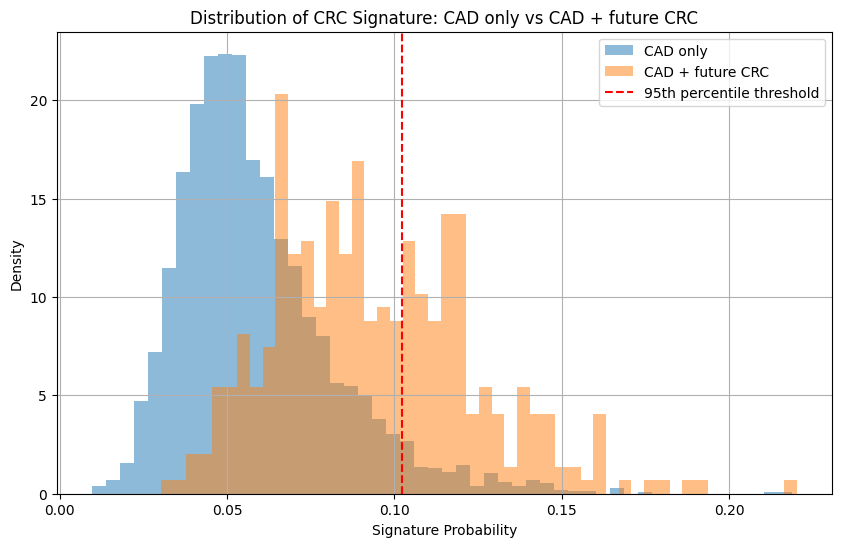

In [62]:
def get_cad_only_patients(base_dir, disease1_idx=0):  # Assuming CAD is disease index 0
    """
    Identify patients who had CAD but didn't develop CRC
    """
    cad_patients = []
    cad_times = []
    
    # Process each batch
    for start_idx in range(0, 400000, 10000):
        end_idx = min(start_idx + 10000, 400000)
        
        try:
            # Load model and Y values for this batch
            model_data = torch.load(os.path.join(base_dir, f'output_{start_idx}_{end_idx}/model.pt'))
            Y = model_data['Y']
            
            # Find patients with CAD but no CRC
            for i in range(len(Y)):
                patient_idx = start_idx + i
                
                # Check if patient has CAD
                cad_times_patient = torch.where(Y[i, disease1_idx] == 1)[0]
                
                if len(cad_times_patient) > 0:  # Has CAD
                    # Check if patient doesn't have CRC
                    if not torch.any(Y[i, 10] == 1):  # Assuming CRC is index 10
                        cad_patients.append(patient_idx)
                        cad_times.append(cad_times_patient[0].item())
    
        except FileNotFoundError:
            continue
    
    # Create DataFrame
    cad_only_df = pd.DataFrame({
        'patient': cad_patients,
        'time_d1': cad_times
    })
    
    print(f"Found {len(cad_only_df)} CAD-only patients")
    return cad_only_df

# Get CAD-only patients
cad_only_df = get_cad_only_patients(base_dir)

# Now run the comparison
def compare_cad_groups(base_dir, sig_refs, results_df, cad_only_df, disease2_idx=10):
    """
    Compare signature patterns between CAD+CRC and CAD-only patients
    """
    # Setup reference trajectory
    healthy_ref = torch.full((1, sig_refs.shape[1]), -5.0)
    full_refs = torch.cat([sig_refs, healthy_ref], dim=0)
    ref_probs = torch.softmax(full_refs, dim=0).numpy()
    
    # Get colon signature
    first_model = torch.load(os.path.join(base_dir, 'output_0_10000/model.pt'))
    phi = first_model['model_state_dict']['phi']
    colon_signature = int(torch.sigmoid(phi[:, disease2_idx, :]).mean(dim=1).argmax().item())
    
    # Track probabilities for both groups
    crc_probs = []  # CAD + CRC group
    cad_probs = []  # CAD only group
    
    # Process each batch
    for start_idx in range(0, 400000, 10000):
        end_idx = min(start_idx + 10000, 400000)
        
        # Get cases from both groups in this batch
        crc_cases = results_df[
            (results_df['patient'] >= start_idx) & 
            (results_df['patient'] < end_idx)
        ]
        cad_cases = cad_only_df[
            (cad_only_df['patient'] >= start_idx) & 
            (cad_only_df['patient'] < end_idx)
        ]
        
        if len(crc_cases) > 0 or len(cad_cases) > 0:
            model = torch.load(os.path.join(base_dir, f'output_{start_idx}_{end_idx}/model.pt'))
            lambda_values = model['model_state_dict']['lambda_']
            thetas = torch.softmax(lambda_values, dim=1)
            
            # Process CRC cases
            for _, case in crc_cases.iterrows():
                patient_idx = int(case['patient'] - start_idx)
                dx_time = int(case['time_d2'])
                time_idx = min(max(0, dx_time - 24), thetas.shape[2]-1)  # 2 years before diagnosis
                prob = thetas[patient_idx, colon_signature, time_idx].item()
                crc_probs.append(prob)
            
            # Process CAD-only cases
            for _, case in cad_cases.iterrows():
                patient_idx = int(case['patient'] - start_idx)
                cad_time = int(case['time_d1'])
                # Take probability at similar timepoint after CAD
                time_idx = min(max(0, cad_time + 24), thetas.shape[2]-1)  # 2 years after CAD
                prob = thetas[patient_idx, colon_signature, time_idx].item()
                cad_probs.append(prob)
    
    # Calculate statistics and plot
    plt.figure(figsize=(10, 6))
    plt.hist(cad_probs, bins=50, alpha=0.5, label='CAD only', density=True)
    plt.hist(crc_probs, bins=50, alpha=0.5, label='CAD + future CRC', density=True)
    
    threshold = np.percentile(cad_probs, 95)
    plt.axvline(threshold, color='r', linestyle='--', label='95th percentile threshold')
    plt.xlabel('Signature Probability')
    plt.ylabel('Density')
    plt.title('Distribution of CRC Signature: CAD only vs CAD + future CRC')
    plt.legend()
    plt.grid(True)
    
    sensitivity = np.mean(np.array(crc_probs) > threshold)
    
    print(f"\nAnalysis Results:")
    print(f"Number of CAD + CRC cases: {len(crc_probs)}")
    print(f"Number of CAD only cases: {len(cad_probs)}")
    print(f"Sensitivity at 95% specificity: {sensitivity:.3f}")
    print(f"\nMean probability:")
    print(f"CAD + CRC: {np.mean(crc_probs):.3f} ± {np.std(crc_probs):.3f}")
    print(f"CAD only: {np.mean(cad_probs):.3f} ± {np.std(cad_probs):.3f}")
    
    return crc_probs, cad_probs, threshold

# Run the comparison
crc_probs, cad_probs, threshold = compare_cad_groups(base_dir, sig_refs=signature_refs, 
                                                    results_df=results_df, cad_only_df=cad_only_df)

In [70]:
def print_disease_names(base_dir):
    """
    Print disease names from the first model's DataFrame
    """
    # Load first model
    first_model = torch.load(os.path.join(base_dir, 'output_0_10000/model.pt'))
    
    # Get disease names DataFrame
    disease_names_df = first_model['disease_names']
    
    print("\nAvailable diseases:")
    # Assuming the disease names are in a column - let's see the structure
    print("\nDataFrame structure:")
    print(disease_names_df.head())
    print("\nColumns:", disease_names_df.columns.tolist())
    
    return disease_names_df

# Look at the disease names DataFrame structure
disease_names_df = print_disease_names(base_dir)


Available diseases:

DataFrame structure:
                           0
0        Bacterial enteritis
1            Viral Enteritis
2   Gram negative septicemia
3    Bacterial infection NOS
4  Staphylococcus infections

Columns: [0]


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_2103/3415850116.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  first_model = torch.load(os.path.join(base_dir

In [71]:
def find_diseases_of_interest(disease_names_df):
    """
    Search for specific diseases and related conditions
    """
    diseases = disease_names_df[0].tolist()  # Get all disease names
    
    print("\nSearching for diseases of interest...")
    
    # Search terms for different conditions
    search_terms = {
        'depression': ['depression', 'depressive', 'mood'],
        'breast_cancer': ['breast', 'mammary'],
        'dementia': ['dementia', 'alzheimer', 'cognitive'],
        'diabetes': ['diabetes', 'diabetic'],
        'heart': ['cad', 'coronary', 'heart', 'cardiac'],
        'cancer': ['cancer', 'neoplasm', 'malignant']
    }
    
    # Find matches
    for category, terms in search_terms.items():
        print(f"\n{category.replace('_', ' ').title()} related conditions:")
        for i, disease in enumerate(diseases):
            if any(term.lower() in disease.lower() for term in terms):
                print(f"{i}: {disease}")

# Find diseases of interest
find_diseases_of_interest(disease_names_df)


Searching for diseases of interest...

Depression related conditions:
66: Major depressive disorder

Breast Cancer related conditions:
16: Breast cancer [female]
17: Malignant neoplasm of female breast
256: Benign neoplasm of breast
257: Lump or mass in breast
258: Hypertrophy of breast (Gynecomastia)

Dementia related conditions:

Diabetes related conditions:
46: Type 1 diabetes
47: Type 2 diabetes
48: Type 2 diabetes with ophthalmic manifestations
49: Diabetic retinopathy

Heart related conditions:
105: Rheumatic disease of the heart valves
111: Unstable angina (intermediate coronary syndrome)
114: Coronary atherosclerosis
115: Other chronic ischemic heart disease, unspecified
116: Other acute and subacute forms of ischemic heart disease
117: Other forms of chronic heart disease
118: Pulmonary heart disease
128: Cardiac arrest
129: Arrhythmia (cardiac) NOS
130: Congestive heart failure (CHF) NOS
131: Heart failure NOS

Cancer related conditions:
10: Colon cancer
11: Malignant neopla

In [78]:
def analyze_multiple_progressions(base_dir, sig_refs, disease_pairs):
    """
    Analyze multiple disease progressions
    """
    results = {}
    
    for disease2_name, disease2_idx in disease_pairs.items():
        print(f"\n\nAnalyzing CAD → {disease2_name} progression")
        
        # Get signature that most strongly predicts second disease
        first_model = torch.load(os.path.join(base_dir, 'output_0_10000/model.pt'))
        phi = first_model['model_state_dict']['phi']
        target_signature = int(torch.sigmoid(phi[:, disease2_idx, :]).mean(dim=1).argmax().item())
        print(f"Disease {disease2_name} is most strongly associated with signature {target_signature}")
        
        # Find progression cases (CAD → disease2)
        progression_df = results_df[results_df['disease2_idx'] == disease2_idx]
        
        # Compare trajectories
        prog_probs, control_probs, threshold = compare_groups(
            base_dir, sig_refs, progression_df, cad_only_df, 
            target_signature, disease2_idx, disease2_name
        )
        
        results[disease2_name] = {
            'progression_probs': prog_probs,
            'control_probs': control_probs,
            'threshold': threshold
        }
    
    return results

# Define disease pairs to analyze
disease_pairs = {
    'Major Depression': 66,
    'Breast Cancer': 17,
    'Type 2 Diabetes': 47
}

# Run analysis for all pairs
results = analyze_multiple_progressions(base_dir, sig_refs=signature_refs, disease_pairs=disease_pairs)



Analyzing CAD → Major Depression progression
Disease Major Depression is most strongly associated with signature 7


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_2103/1605913122.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  first_model = torch.load(os.path.join(base_di

KeyError: 'disease2_idx'

In [74]:
results_df

,patient,time_d1,time_d2,gap,years_between
0,1593,39,48,9,0.750000
1,1636,48,50,2,0.166667
2,3485,12,28,16,1.333333
3,4471,33,49,16,1.333333
4,6154,38,45,7,0.583333
...,...,...,...,...,...
384,397524,44,46,2,0.166667
385,397853,35,47,12,1.000000
386,399306,19,24,5,0.416667
387,399609,22,38,16,1.333333




Analyzing CAD → Major Depression progression


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_2103/1432669144.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_data = torch.load(os.path.join(base_dir

Found 1829 cases of progression to Major Depression
Disease Major Depression is most strongly associated with signature 7


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_2103/1432669144.py:73: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  first_model = torch.load(os.path.join(base_di


Analysis Results for Major Depression:
Number of CAD + Major Depression cases: 1829
Number of CAD only cases: 3487
Sensitivity at 95% specificity: 0.101

Mean probability:
CAD + Major Depression: 0.149 ± 0.046
CAD only: 0.130 ± 0.041


Analyzing CAD → Malignant Breast Neoplasm progression
Found 229 cases of progression to Malignant Breast Neoplasm
Disease Malignant Breast Neoplasm is most strongly associated with signature 19

Analysis Results for Malignant Breast Neoplasm:
Number of CAD + Malignant Breast Neoplasm cases: 229
Number of CAD only cases: 3487
Sensitivity at 95% specificity: 0.009

Mean probability:
CAD + Malignant Breast Neoplasm: 0.043 ± 0.011
CAD only: 0.047 ± 0.013


Analyzing CAD → Type 2 Diabetes progression
Found 3281 cases of progression to Type 2 Diabetes
Disease Type 2 Diabetes is most strongly associated with signature 15

Analysis Results for Type 2 Diabetes:
Number of CAD + Type 2 Diabetes cases: 3281
Number of CAD only cases: 3487
Sensitivity at 95% specific

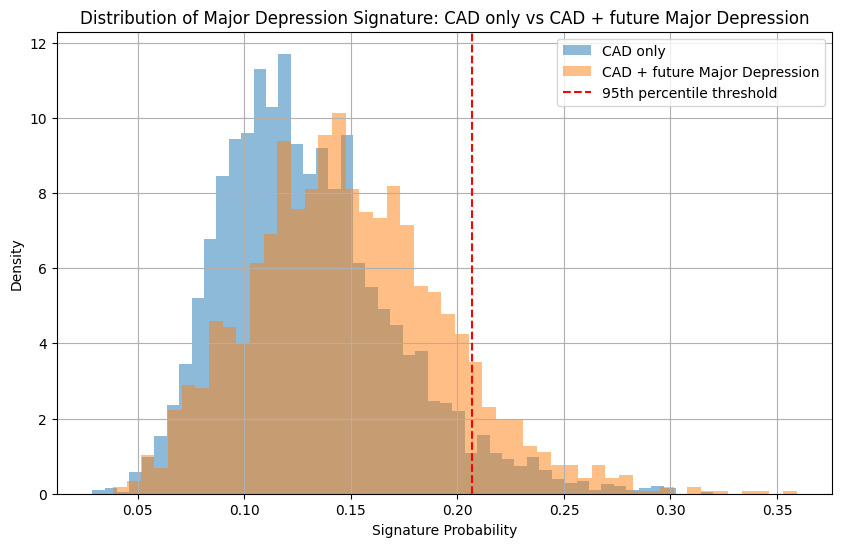

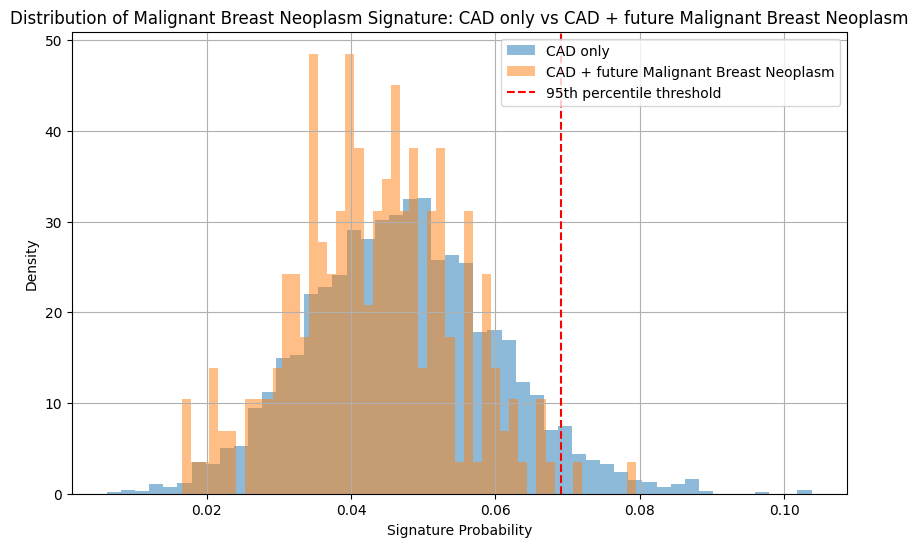

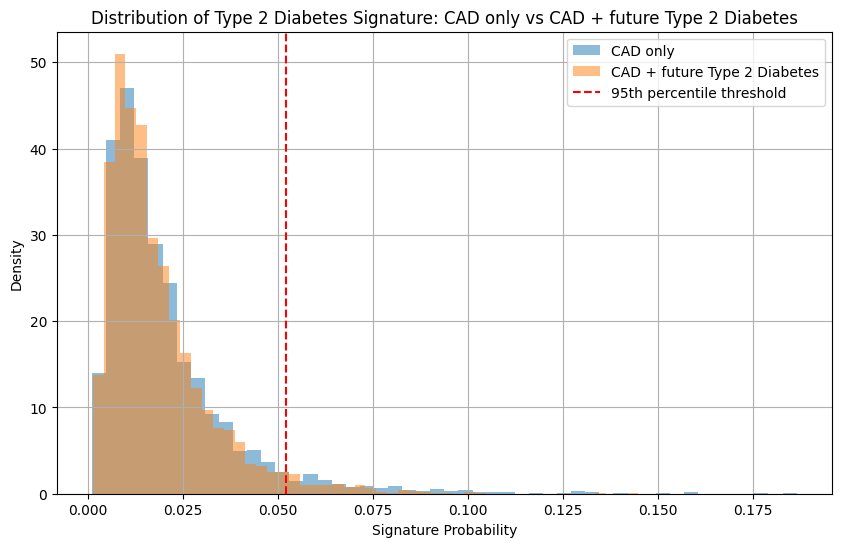

In [81]:
def analyze_multiple_progressions(base_dir, sig_refs, disease_pairs):
    """
    Analyze multiple disease progressions
    """
    all_results = {}
    
    # First get CAD-only cases if we haven't already
    if 'cad_only_df' not in globals():
        cad_only_cases = []
        for start_idx in range(0, 400000, 10000):
            end_idx = min(start_idx + 10000, 400000)
            try:
                model_data = torch.load(os.path.join(base_dir, f'output_{start_idx}_{end_idx}/model.pt'))
                Y = model_data['Y']
                
                # Check each patient in this batch
                for i in range(len(Y)):
                    patient_idx = start_idx + i
                    # Has CAD (114) but none of our target diseases
                    if torch.any(Y[i, 114] == 1) and not any(torch.any(Y[i, d] == 1) for d in disease_pairs.values()):
                        cad_time = torch.where(Y[i, 114] == 1)[0][0].item()
                        cad_only_cases.append({
                            'patient': patient_idx,
                            'time_d1': cad_time
                        })
            except FileNotFoundError:
                continue
        
        global cad_only_df
        cad_only_df = pd.DataFrame(cad_only_cases)
        print(f"Found {len(cad_only_df)} CAD-only cases")
    
    # Now analyze each disease progression
    for disease2_name, disease2_idx in disease_pairs.items():
        print(f"\n\nAnalyzing CAD → {disease2_name} progression")
        
        # Create new progression DataFrame for this disease
        progression_cases = []
        
        # Process each batch to find cases of this specific progression
        for start_idx in range(0, 400000, 10000):
            end_idx = min(start_idx + 10000, 400000)
            try:
                model_data = torch.load(os.path.join(base_dir, f'output_{start_idx}_{end_idx}/model.pt'))
                Y = model_data['Y']
                
                # Check each patient in this batch
                for i in range(len(Y)):
                    patient_idx = start_idx + i
                    
                    # Check if patient has CAD then disease2
                    if torch.any(Y[i, 114] == 1) and torch.any(Y[i, disease2_idx] == 1):
                        cad_time = torch.where(Y[i, 114] == 1)[0][0].item()
                        disease2_time = torch.where(Y[i, disease2_idx] == 1)[0][0].item()
                        
                        if cad_time < disease2_time:  # CAD before disease2
                            progression_cases.append({
                                'patient': patient_idx,
                                'time_d1': cad_time,
                                'time_d2': disease2_time,
                                'gap': disease2_time - cad_time,
                                'years_between': (disease2_time - cad_time) / 12
                            })
            except FileNotFoundError:
                continue
        
        # Create DataFrame for this progression
        prog_df = pd.DataFrame(progression_cases)
        print(f"Found {len(prog_df)} cases of progression to {disease2_name}")
        
        if len(prog_df) > 0:
            # Get signature that most strongly predicts second disease
            first_model = torch.load(os.path.join(base_dir, 'output_0_10000/model.pt'))
            phi = first_model['model_state_dict']['phi']
            target_signature = int(torch.sigmoid(phi[:, disease2_idx, :]).mean(dim=1).argmax().item())
            print(f"Disease {disease2_name} is most strongly associated with signature {target_signature}")
            
            # Compare trajectories
            prog_probs, control_probs, threshold = compare_groups(
                base_dir, sig_refs, prog_df, cad_only_df, 
                target_signature, disease2_idx, disease2_name
            )
            
            all_results[disease2_name] = {
                'progression_probs': prog_probs,
                'control_probs': control_probs,
                'threshold': threshold,
                'n_cases': len(prog_df)
            }
        else:
            print(f"No progression cases found for {disease2_name}")
    
    return all_results

# Define disease pairs to analyze
disease_pairs = {
    'Major Depression': 66,
    'Malignant Breast Neoplasm': 17,  # Changed to malignant neoplasm of female breast
    'Type 2 Diabetes': 47
    "Cerebrovascular disease":
}

# Run analysis for all pairs
results = analyze_multiple_progressions(base_dir, sig_refs=signature_refs, disease_pairs=disease_pairs)

In [ ]:
def print_disease_names(base_dir):
    """
    Print disease names from the first model's DataFrame
    """
    # Load first model
    first_model = torch.load(os.path.join(base_dir, 'output_0_10000/model.pt'))
    
    # Get disease names DataFrame
    disease_names_df = first_model['disease_names']
    
    print("\nAvailable diseases:")
    # Assuming the disease names are in a column - let's see the structure
    print("\nDataFrame structure:")
    print(disease_names_df.head())
    print("\nColumns:", disease_names_df.columns.tolist())
    
    return disease_names_df

# Look at the disease names DataFrame structure
disease_names_df = print_disease_names(base_dir)


Available diseases:

DataFrame structure:
                           0
0        Bacterial enteritis
1            Viral Enteritis
2   Gram negative septicemia
3    Bacterial infection NOS
4  Staphylococcus infections

Columns: [0]


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_2103/3415850116.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  first_model = torch.load(os.path.join(base_dir

/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_2103/1951554032.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  first_model = torch.load(os.path.join(base_dir


Analysis Results:
Number of primary breast cancer cases: 16608
Number of CAD → breast cancer cases: 229

Mean probability:
Primary breast cancer: 0.050 ± 0.011
CAD → breast cancer: 0.043 ± 0.011


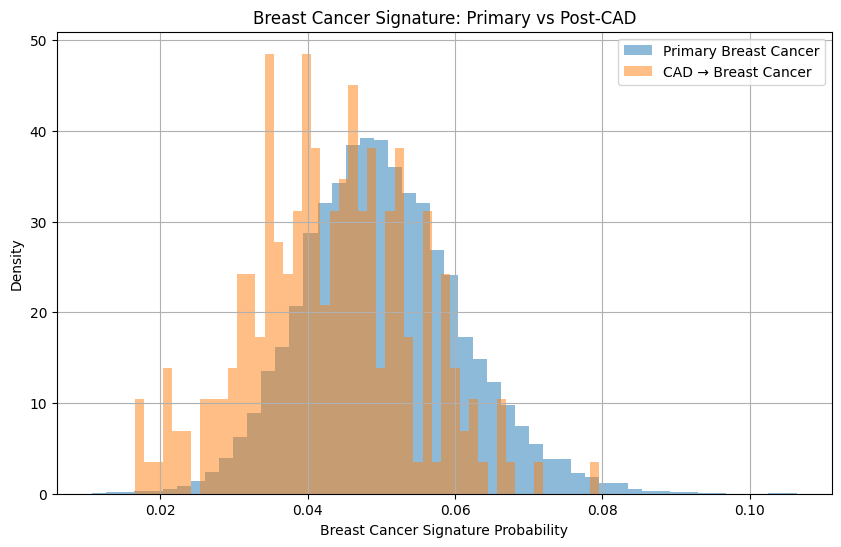

In [82]:
def compare_signature_patterns(base_dir, disease_idx=17, sig_refs=None):
    """
    Compare signature patterns between:
    1. CAD → Breast Cancer patients
    2. Primary Breast Cancer patients (no prior CAD)
    """
    # Get breast cancer signature
    first_model = torch.load(os.path.join(base_dir, 'output_0_10000/model.pt'))
    phi = first_model['model_state_dict']['phi']
    bc_signature = int(torch.sigmoid(phi[:, disease_idx, :]).mean(dim=1).argmax().item())
    
    cad_bc_probs = []  # CAD → BC progression
    primary_bc_probs = []  # Primary BC
    
    # Process each batch
    for start_idx in range(0, 400000, 10000):
        end_idx = min(start_idx + 10000, 400000)
        try:
            model_data = torch.load(os.path.join(base_dir, f'output_{start_idx}_{end_idx}/model.pt'))
            Y = model_data['Y']
            lambda_values = model_data['model_state_dict']['lambda_']
            thetas = torch.softmax(lambda_values, dim=1)
            
            # Check each patient
            for i in range(len(Y)):
                patient_idx = start_idx + i
                
                # If patient has breast cancer
                if torch.any(Y[i, disease_idx] == 1):
                    bc_time = torch.where(Y[i, disease_idx] == 1)[0][0].item()
                    
                    # Get probability 2 years before diagnosis
                    time_idx = max(0, bc_time - 24)
                    prob = thetas[i, bc_signature, time_idx].item()
                    
                    # Check if they had prior CAD
                    had_prior_cad = torch.any(Y[i, 114] == 1)
                    if had_prior_cad:
                        cad_time = torch.where(Y[i, 114] == 1)[0][0].item()
                        if cad_time < bc_time:  # CAD before BC
                            cad_bc_probs.append(prob)
                    else:  # No prior CAD
                        primary_bc_probs.append(prob)
                        
        except FileNotFoundError:
            continue
    
    # Plot distributions
    plt.figure(figsize=(10, 6))
    plt.hist(primary_bc_probs, bins=50, alpha=0.5, label='Primary Breast Cancer', density=True)
    plt.hist(cad_bc_probs, bins=50, alpha=0.5, label='CAD → Breast Cancer', density=True)
    plt.xlabel('Breast Cancer Signature Probability')
    plt.ylabel('Density')
    plt.title('Breast Cancer Signature: Primary vs Post-CAD')
    plt.legend()
    plt.grid(True)
    
    # Print statistics
    print("\nAnalysis Results:")
    print(f"Number of primary breast cancer cases: {len(primary_bc_probs)}")
    print(f"Number of CAD → breast cancer cases: {len(cad_bc_probs)}")
    print(f"\nMean probability:")
    print(f"Primary breast cancer: {np.mean(primary_bc_probs):.3f} ± {np.std(primary_bc_probs):.3f}")
    print(f"CAD → breast cancer: {np.mean(cad_bc_probs):.3f} ± {np.std(cad_bc_probs):.3f}")
    
    return primary_bc_probs, cad_bc_probs

# Run the comparison
primary_probs, cad_bc_probs = compare_signature_patterns(base_dir, disease_idx=17)

In [ ]:
def compare_signature_patterns(base_dir, disease_idx=66, sig_refs=None):
    """
    Compare signature patterns between:
    1. CAD → Breast Cancer patients
    2. Primary Breast Cancer patients (no prior CAD)
    """
    # Get breast cancer signature
    first_model = torch.load(os.path.join(base_dir, 'output_0_10000/model.pt'))
    phi = first_model['model_state_dict']['phi']
    bc_signature = int(torch.sigmoid(phi[:, disease_idx, :]).mean(dim=1).argmax().item())
    
    cad_bc_probs = []  # CAD → BC progression
    primary_bc_probs = []  # Primary BC
    
    # Process each batch
    for start_idx in range(0, 400000, 10000):
        end_idx = min(start_idx + 10000, 400000)
        try:
            model_data = torch.load(os.path.join(base_dir, f'output_{start_idx}_{end_idx}/model.pt'))
            Y = model_data['Y']
            lambda_values = model_data['model_state_dict']['lambda_']
            thetas = torch.softmax(lambda_values, dim=1)
            
            # Check each patient
            for i in range(len(Y)):
                patient_idx = start_idx + i
                
                # If patient has breast cancer
                if torch.any(Y[i, disease_idx] == 1):
                    bc_time = torch.where(Y[i, disease_idx] == 1)[0][0].item()
                    
                    # Get probability 2 years before diagnosis
                    time_idx = max(0, bc_time - 24)
                    prob = thetas[i, bc_signature, time_idx].item()
                    
                    # Check if they had prior CAD
                    had_prior_cad = torch.any(Y[i, 114] == 1)
                    if had_prior_cad:
                        cad_time = torch.where(Y[i, 114] == 1)[0][0].item()
                        if cad_time < bc_time:  # CAD before BC
                            cad_bc_probs.append(prob)
                    else:  # No prior CAD
                        primary_bc_probs.append(prob)
                        
        except FileNotFoundError:
            continue
    
    # Plot distributions
    plt.figure(figsize=(10, 6))
    plt.hist(primary_bc_probs, bins=50, alpha=0.5, label='Primary Breast Cancer', density=True)
    plt.hist(cad_bc_probs, bins=50, alpha=0.5, label='CAD → Breast Cancer', density=True)
    plt.xlabel('Breast Cancer Signature Probability')
    plt.ylabel('Density')
    plt.title('Breast Cancer Signature: Primary vs Post-CAD')
    plt.legend()
    plt.grid(True)
    
    # Print statistics
    print("\nAnalysis Results:")
    print(f"Number of primary breast cancer cases: {len(primary_bc_probs)}")
    print(f"Number of CAD → breast cancer cases: {len(cad_bc_probs)}")
    print(f"\nMean probability:")
    print(f"Primary breast cancer: {np.mean(primary_bc_probs):.3f} ± {np.std(primary_bc_probs):.3f}")
    print(f"CAD → breast cancer: {np.mean(cad_bc_probs):.3f} ± {np.std(cad_bc_probs):.3f}")
    
    return primary_bc_probs, cad_bc_probs

# Run the comparison
primary_probs, cad_bc_probs = compare_signature_patterns(base_dir, disease_idx=17)

In [89]:
def show_all_diseases(disease_names_df):
    """
    Print all disease names with their indices
    """
    print("\nAll diseases:")
    for i, disease in enumerate(disease_names_df[0]):
        print(f"{i}: {disease}")

# Show all diseases
show_all_diseases(disease_names_df)


All diseases:
0: Bacterial enteritis
1: Viral Enteritis
2: Gram negative septicemia
3: Bacterial infection NOS
4: Staphylococcus infections
5: Streptococcus infection
6: E. coli
7: Viral warts & HPV
8: Viral infection
9: Candidiasis
10: Colon cancer
11: Malignant neoplasm of rectum, rectosigmoid junction, and anus
12: Neoplasm of unspecified nature of digestive system
13: Cancer of bronchus; lung
14: Melanomas of skin
15: Other non-epithelial cancer of skin
16: Breast cancer [female]
17: Malignant neoplasm of female breast
18: Cervical intraepithelial neoplasia [CIN] [Cervical dysplasia]
19: Malignant neoplasm of uterus
20: Malignant neoplasm of ovary
21: Cancer of prostate
22: Malignant neoplasm of kidney, except pelvis
23: Malignant neoplasm of bladder
24: Malignant neoplasm, other
25: Secondary malignant neoplasm
26: Secondary malignancy of lymph nodes
27: Secondary malignancy of respiratory organs
28: Secondary malignant neoplasm of digestive systems
29: Secondary malignant neopla

In [90]:
disease_pairs = {
    'Cerebrovascular Disease': 132,
    'Colon Cancer': 10,
    'Major Depression': 66
}

# Run comparison for each disease
for disease_name, disease_idx in disease_pairs.items():
    print(f"\nAnalyzing CAD → {disease_name}")
    primary_probs, cad_progression_probs = compare_signature_patterns(
        base_dir, 
        disease_idx=disease_idx,
        disease2_name=disease_name
    )


Analyzing CAD → Cerebrovascular Disease


TypeError: compare_signature_patterns() got an unexpected keyword argument 'disease2_name'


Analyzing CAD → Cerebrovascular Disease


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_2103/3261972880.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  first_model = torch.load(os.path.join(base_dir


Analysis Results:
Number of primary cases: 3727
Number of CAD → progression cases: 672

Mean probability:
Primary cases: 0.004 ± 0.002
CAD → progression: 0.005 ± 0.002

Analyzing CAD → Colon Cancer

Analysis Results:
Number of primary cases: 5989
Number of CAD → progression cases: 389

Mean probability:
Primary cases: 0.096 ± 0.029
CAD → progression: 0.094 ± 0.030

Analyzing CAD → Major Depression

Analysis Results:
Number of primary cases: 26805
Number of CAD → progression cases: 1829

Mean probability:
Primary cases: 0.126 ± 0.046
CAD → progression: 0.149 ± 0.046

Analyzing CAD → Breast Cancer

Analysis Results:
Number of primary cases: 16608
Number of CAD → progression cases: 229

Mean probability:
Primary cases: 0.050 ± 0.011
CAD → progression: 0.043 ± 0.011


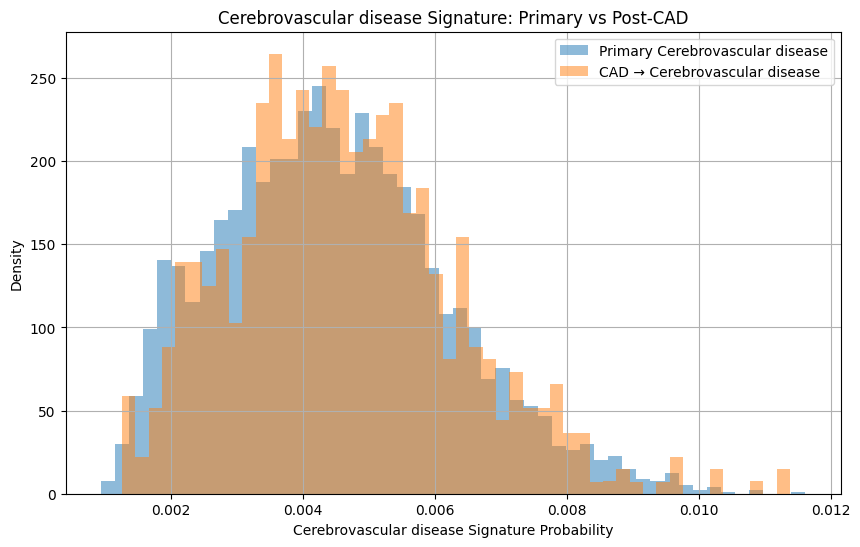

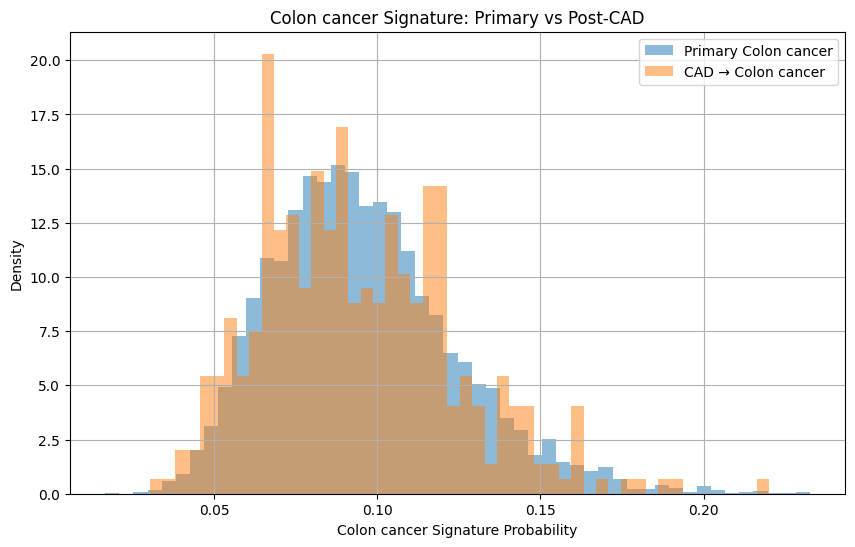

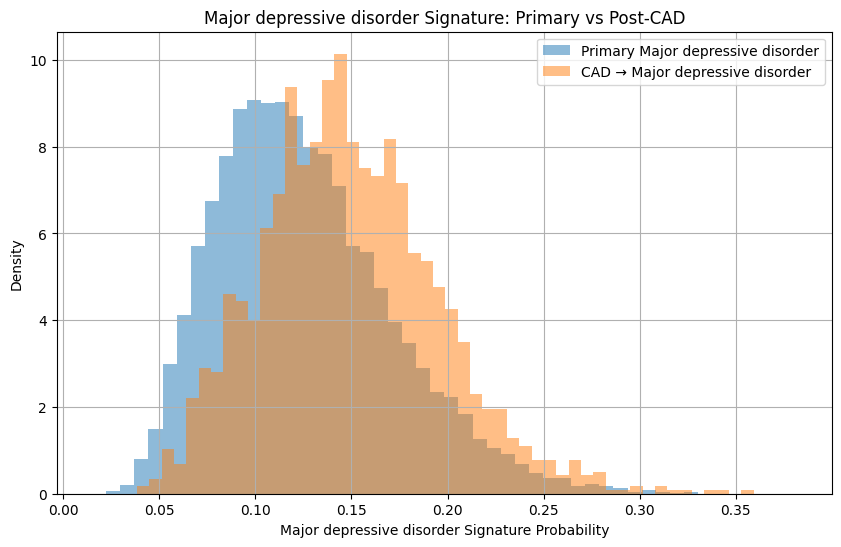

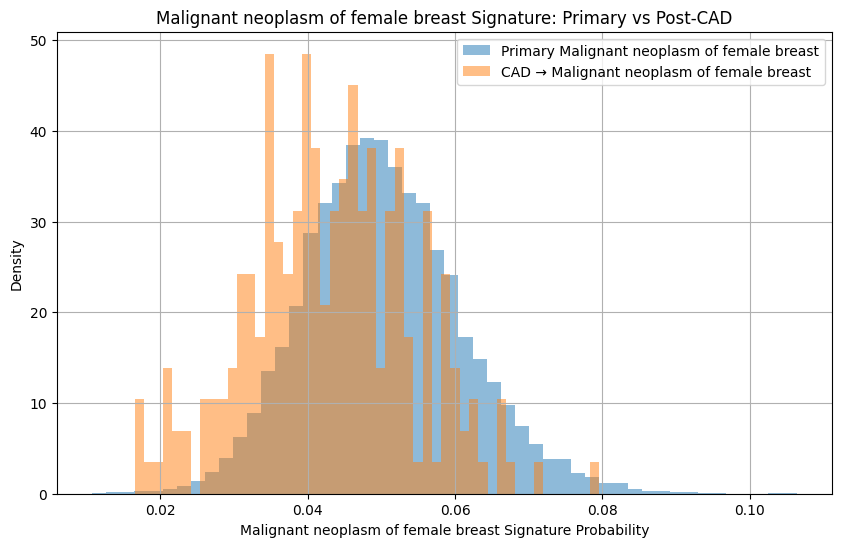

In [92]:
def compare_signature_patterns(base_dir, disease_idx, sig_refs=None):
    """
    Compare signature patterns between:
    1. CAD → Disease progression
    2. Primary Disease cases (no prior CAD)
    """
    # Get disease signature
    first_model = torch.load(os.path.join(base_dir, 'output_0_10000/model.pt'))
    phi = first_model['model_state_dict']['phi']
    disease_signature = int(torch.sigmoid(phi[:, disease_idx, :]).mean(dim=1).argmax().item())
    
    cad_progression_probs = []  # CAD → Disease progression
    primary_probs = []  # Primary Disease
    
    # Process each batch
    for start_idx in range(0, 400000, 10000):
        end_idx = min(start_idx + 10000, 400000)
        try:
            model_data = torch.load(os.path.join(base_dir, f'output_{start_idx}_{end_idx}/model.pt'))
            Y = model_data['Y']
            lambda_values = model_data['model_state_dict']['lambda_']
            thetas = torch.softmax(lambda_values, dim=1)
            
            # Check each patient
            for i in range(len(Y)):
                patient_idx = start_idx + i
                
                # If patient has the disease
                if torch.any(Y[i, disease_idx] == 1):
                    disease_time = torch.where(Y[i, disease_idx] == 1)[0][0].item()
                    
                    # Get probability 2 years before diagnosis
                    time_idx = max(0, disease_time - 24)
                    prob = thetas[i, disease_signature, time_idx].item()
                    
                    # Check if they had prior CAD
                    had_prior_cad = torch.any(Y[i, 114] == 1)
                    if had_prior_cad:
                        cad_time = torch.where(Y[i, 114] == 1)[0][0].item()
                        if cad_time < disease_time:  # CAD before disease
                            cad_progression_probs.append(prob)
                    else:  # No prior CAD
                        primary_probs.append(prob)
                        
        except FileNotFoundError:
            continue
    
    # Plot distributions
    plt.figure(figsize=(10, 6))
    plt.hist(primary_probs, bins=50, alpha=0.5, label=f'Primary {first_model["disease_names"][0][disease_idx]}', density=True)
    plt.hist(cad_progression_probs, bins=50, alpha=0.5, label=f'CAD → {first_model["disease_names"][0][disease_idx]}', density=True)
    plt.xlabel(f'{first_model["disease_names"][0][disease_idx]} Signature Probability')
    plt.ylabel('Density')
    plt.title(f'{first_model["disease_names"][0][disease_idx]} Signature: Primary vs Post-CAD')
    plt.legend()
    plt.grid(True)
    
    # Print statistics
    print("\nAnalysis Results:")
    print(f"Number of primary cases: {len(primary_probs)}")
    print(f"Number of CAD → progression cases: {len(cad_progression_probs)}")
    print(f"\nMean probability:")
    print(f"Primary cases: {np.mean(primary_probs):.3f} ± {np.std(primary_probs):.3f}")
    print(f"CAD → progression: {np.mean(cad_progression_probs):.3f} ± {np.std(cad_progression_probs):.3f}")
    
    return primary_probs, cad_progression_probs

# Run comparison for each disease
disease_pairs = {
    'Cerebrovascular Disease': 132,
    'Colon Cancer': 10,
    'Major Depression': 66,
    'Breast Cancer':17
}

for disease_name, disease_idx in disease_pairs.items():
    print(f"\nAnalyzing CAD → {disease_name}")
    primary_probs, cad_progression_probs = compare_signature_patterns(
        base_dir, 
        disease_idx=disease_idx
    )


Analyzing temporal patterns for Breast Cancer


/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_2103/3580732171.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_data = torch.load(os.path.join(base_dir


Found 16606 primary cases
Found 229 CAD progression cases

Analyzing temporal patterns for Major Depression

Found 26779 primary cases
Found 1829 CAD progression cases


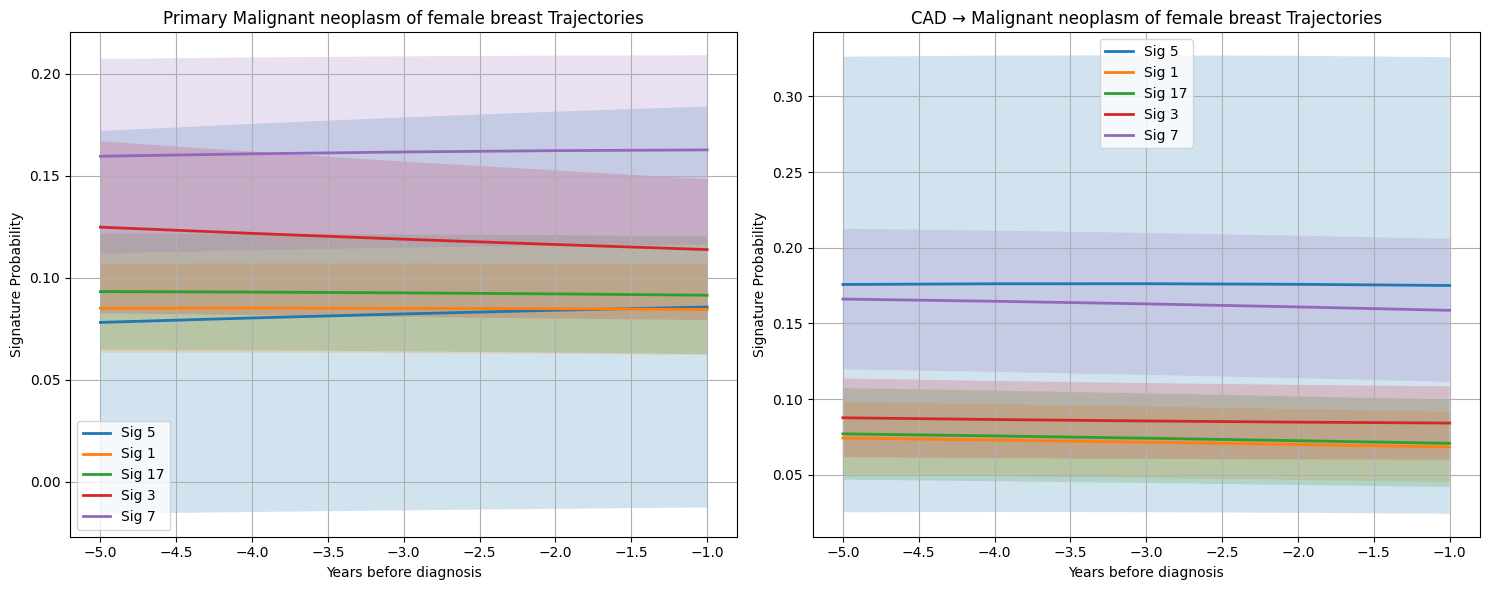

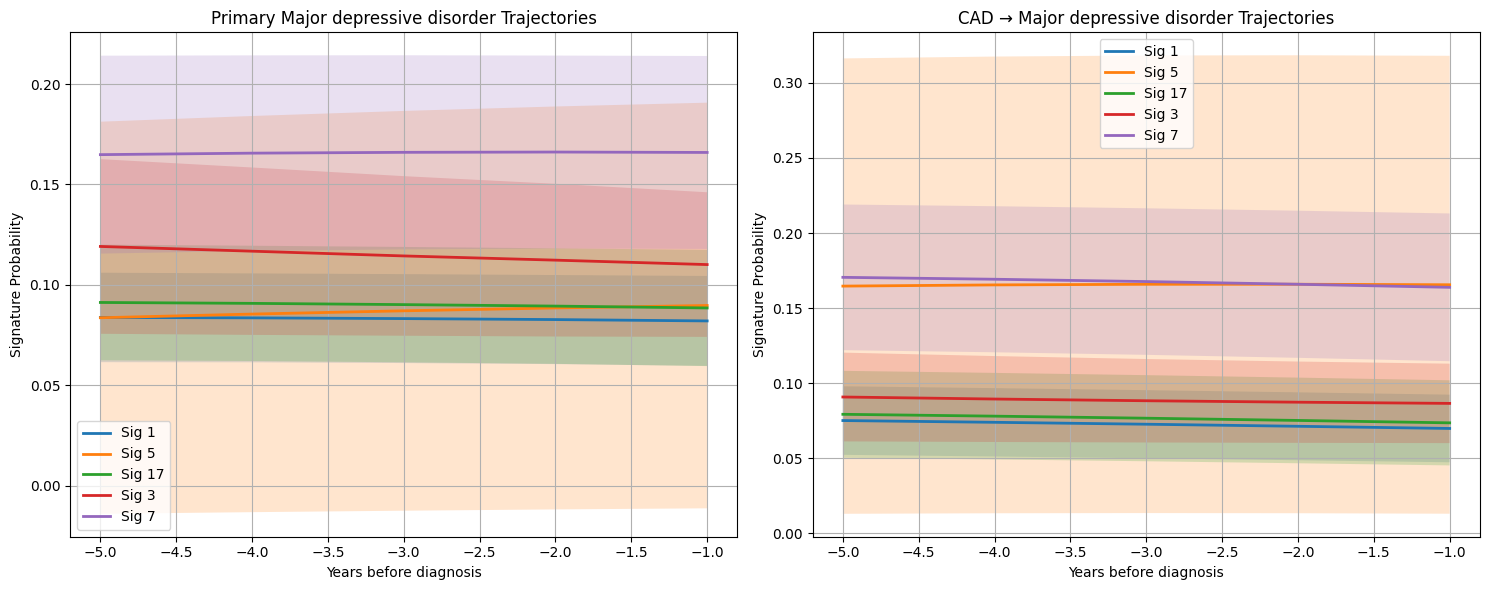

In [95]:
def analyze_temporal_signatures(base_dir, disease_idx, window_size=5):  # 5 years window
    """
    Analyze temporal signature patterns before disease diagnosis
    All time units are in years
    """
    primary_trajectories = []
    cad_trajectories = []
    
    # Process each batch
    for start_idx in range(0, 400000, 10000):
        end_idx = min(start_idx + 10000, 400000)
        try:
            model_data = torch.load(os.path.join(base_dir, f'output_{start_idx}_{end_idx}/model.pt'))
            Y = model_data['Y']
            lambda_values = model_data['model_state_dict']['lambda_']
            thetas = torch.softmax(lambda_values, dim=1)
            
            # Get disease signature
            phi = model_data['model_state_dict']['phi']
            disease_signature = int(torch.sigmoid(phi[:, disease_idx, :]).mean(dim=1).argmax().item())
            
            # Check each patient
            for i in range(len(Y)):
                if torch.any(Y[i, disease_idx] == 1):
                    disease_time = torch.where(Y[i, disease_idx] == 1)[0][0].item()
                    
                    # Get trajectory for fixed window before diagnosis
                    start_time = max(0, disease_time - window_size)
                    time_points = disease_time - start_time
                    
                    # Only include if we have enough history
                    if time_points >= window_size//2:  # At least half the window
                        # Pad with zeros if needed
                        trajectory = np.zeros((thetas.shape[1], window_size))
                        actual_data = thetas[i, :, start_time:disease_time].numpy()
                        trajectory[:, -time_points:] = actual_data
                        
                        # Check if they had prior CAD
                        had_prior_cad = torch.any(Y[i, 114] == 1)
                        if had_prior_cad:
                            cad_time = torch.where(Y[i, 114] == 1)[0][0].item()
                            if cad_time < disease_time:
                                cad_trajectories.append(trajectory)
                        else:
                            primary_trajectories.append(trajectory)
                        
        except FileNotFoundError:
            continue
    
    # Convert to arrays
    primary_trajectories = np.array(primary_trajectories)
    cad_trajectories = np.array(cad_trajectories)
    
    print(f"\nFound {len(primary_trajectories)} primary cases")
    print(f"Found {len(cad_trajectories)} CAD progression cases")
    
    if len(primary_trajectories) == 0 or len(cad_trajectories) == 0:
        print("Not enough cases for analysis")
        return None, None
    
    # Plot average trajectories for top signatures
    plt.figure(figsize=(15, 6))
    
    # Plot primary cases
    plt.subplot(1, 2, 1)
    mean_primary = np.mean(primary_trajectories, axis=0)
    std_primary = np.std(primary_trajectories, axis=0)
    top_sigs = np.argsort(mean_primary.mean(axis=1))[-5:]  # Top 5 signatures
    
    for sig in top_sigs:
        plt.plot(range(-window_size, 0), mean_primary[sig], 
                label=f'Sig {sig}', linewidth=2)
        plt.fill_between(range(-window_size, 0),
                        mean_primary[sig] - std_primary[sig],
                        mean_primary[sig] + std_primary[sig],
                        alpha=0.2)
    
    plt.title(f'Primary {model_data["disease_names"][0][disease_idx]} Trajectories')
    plt.xlabel('Years before diagnosis')
    plt.ylabel('Signature Probability')
    plt.legend()
    plt.grid(True)
    
    # Plot CAD progression cases
    plt.subplot(1, 2, 2)
    mean_cad = np.mean(cad_trajectories, axis=0)
    std_cad = np.std(cad_trajectories, axis=0)
    
    for sig in top_sigs:
        plt.plot(range(-window_size, 0), mean_cad[sig], 
                label=f'Sig {sig}', linewidth=2)
        plt.fill_between(range(-window_size, 0),
                        mean_cad[sig] - std_cad[sig],
                        mean_cad[sig] + std_cad[sig],
                        alpha=0.2)
    
    plt.title(f'CAD → {model_data["disease_names"][0][disease_idx]} Trajectories')
    plt.xlabel('Years before diagnosis')
    plt.ylabel('Signature Probability')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    
    return primary_trajectories, cad_trajectories

# Run for breast cancer and depression
diseases = {
    'Breast Cancer': 17,
    'Major Depression': 66
}

for disease_name, disease_idx in diseases.items():
    print(f"\nAnalyzing temporal patterns for {disease_name}")
    primary_traj, cad_traj = analyze_temporal_signatures(base_dir, disease_idx)